<a href="https://colab.research.google.com/github/hairulysin/Support-Vector-Machines/blob/main/notebook_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TIME SERIES FORECASTING

---
DISUSUN OLEH : HAIRUL YASIN








**Time series forecasting** adalah sebuah area pada machine learning yang berfokus pada atribut waktu. Sesuai namanya, bidang ini berfokus pada analisis rentetan data yang sekuensial terhadap waktu, lalu memprediksi data-data yang akan datang berdasarkan data sebelumnya. Singkatnya, Time Series adalah rentetan kejadian atau pengamatan diambil secara sekuensial terhadap waktu. Contoh mudahnya adalah kumpulan data penjualan barang per bulan selama 5 bulan berturut-turut. 

Dataset yang kami gunakan kali ini bersumber pada kagle, dimana data tersebut berasal dari perusahaan ekuador yang dikenal sebagai Corporación Favorita. Tujuan utama dari program ini ialah memprediksi penjualan kedepannya. ada 6 data yang kami gunakan kali ini, diantaranya data latih, data uji, toko, transakasi, liburan dan acara serta data harga minyak harian.




![](https://storage.googleapis.com/kaggle-competitions/kaggle/29781/logos/header.png?t=2021-09-22-19-59-35)

# Store Sales - Time Series Forecasting

pokok pembahasan kami bagi menjadi bebrapa bagian, seperti 
Interpolasi untuk Harga Minyak

1.   Interpolarasi Untuk Harga Minyak
2.   Manipulasi Data Detail  
3.   Liburan dan Acara
4.   Analisis dan Eksplorasi
5.   Pengujian Hipotesis
6.   Pemodelan





<br>

<center><img src="https://github.com/EkremBayar/Kaggle/blob/main/Images/CF.png?raw=true" style="width:30%;height:10%;"></center>

<center><img src="https://github.com/EkremBayar/Kaggle/blob/main/Images/CF1.jpg?raw=true" style="width:30%;height:10%;"></center>

# 1. Packages

Import Paket yang dibutuhkan


In [ ]:
# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os # untuk mengakses fitur-fitur os dari dalam skrip py.
import gc # garbage collector - menanganai penghapusan objek yang tidak digunakan lagi dari memori
import warnings # untuk mengelola peringatan yang dikeluarkan interpreter python

# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm # menyediakan berbagai macam alat dan teknik statitistik yang digunnakan dlm analisis data

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt # membuat plot/grafik
import seaborn as sns
import plotly.express as px


# CONFIGURATIONS
# ------------------------------------------------------
# mengelola tampilan data di py
pd.set_option('display.max_columns', None) # mengatur jumlah maksimum kolom yang ditampilkan, None menandakan bahwa semua kolom akan ditampilkan
pd.options.display.float_format = '{:.2f}'.format # mengatur format tampilan angka pecahan. {:.2f} berarti hnya 2 angka diblkng koma
warnings.filterwarnings('ignore') # menyembunyikan peringatan warning dari interpreter py

# 2. Importing Data

Import semua data yang akan dipakai


In [ ]:
# Import
train = pd.read_csv("/train.csv")
test = pd.read_csv("/test.csv")
stores = pd.read_csv("/stores.csv")
sub = pd.read_csv("/submission.csv")   
transactions = pd.read_csv("/transactions.csv").sort_values(["store_nbr", "date"])
holidays = pd.read_csv("/holidays_events.csv")
oil = pd.read_csv("/oil.csv")
sample_sub = pd.read_csv("/sample_submission.csv")

# Datetime
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)

# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE   0.00         0.00
1   1 2013-01-01          1   BABY CARE   0.00         0.00
2   2 2013-01-01          1      BEAUTY   0.00         0.00
3   3 2013-01-01          1   BEVERAGES   0.00         0.00
4   4 2013-01-01          1       BOOKS   0.00         0.00

# 3. Transactions

**Let's start with the transaction data**

In [ ]:
transactions.head(10)

date  store_nbr  transactions
1   2013-01-02          1          2111
47  2013-01-03          1          1833
93  2013-01-04          1          1863
139 2013-01-05          1          1509
185 2013-01-06          1           520
231 2013-01-07          1          1807
277 2013-01-08          1          1869
323 2013-01-09          1          1910
369 2013-01-10          1          1679
415 2013-01-11          1          1813

In [ ]:
temp = pd.merge(train.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions, how = "left")
print("Spearman Correlation between Total Sales and Transactions: {:,.4f}".format(temp.corr("spearman").sales.loc["transactions"]))
px.line(transactions.sort_values(["store_nbr", "date"]), x='date', y='transactions', color='store_nbr',title = "Transactions" )

Kode di atas merupakan beberapa perintah yang dapat digunakan untuk menghitung korelasi antara dua kolom di dalam DataFrame dan memvisualisasikan hasilnya.

Pada kode pertama, terdapat perintah pd.merge yang digunakan untuk menggabungkan (merge) dua DataFrame berdasarkan kolom yang sama. Di sini, DataFrame train dan transactions di-merge berdasarkan kolom date dan store_nbr.

Setelah itu, perintah corr digunakan untuk menghitung korelasi antara kolom sales dan transactions di dalam DataFrame yang baru saja di-merge. Argumen spearman yang diberikan kepada perintah corr menandakan bahwa korelasi Spearman akan dihitung.

Pada kode kedua, terdapat perintah px.line yang merupakan fungsi dari modul plotly.express. Fungsi ini digunakan untuk membuat plot garis dari data. Di sini, data yang digunakan adalah DataFrame transactions yang telah diurutkan berdasarkan kolom store_nbr dan date. Kolom date akan digunakan sebagai sumbu x, sedangkan kolom transactions akan digunakan sebagai sumbu y. Selain itu, plot juga akan diberi warna berdasarkan kolom store_nbr

In [ ]:
a = transactions.copy()
a["year"] = a.date.dt.year
a["month"] = a.date.dt.month
px.box(a, x="year", y="transactions" , color = "month", title = "Transactions")


Kode di atas merupakan beberapa perintah yang dapat digunakan untuk menambahkan kolom baru ke dalam DataFrame dan memvisualisasikan data menggunakan plot box.

Pertama, DataFrame transactions disalin ke dalam DataFrame baru bernama a menggunakan perintah copy. Kemudian, kolom baru bernama year dan month ditambahkan ke dalam DataFrame a. Kolom year berisi tahun dari tanggal yang tersimpan di kolom date, sedangkan kolom month berisi bulan dari tanggal yang tersimpan di kolom date.

Setelah itu, perintah px.box digunakan untuk membuat plot box dari data. Di sini, data yang digunakan adalah DataFrame a. Kolom year akan digunakan sebagai sumbu x, sedangkan kolom transactions akan digunakan sebagai sumbu y. Selain itu, plot juga akan diberi warna berdasarkan kolom month.

Hasil yang diperoleh dari kode di atas adalah sebuah plot box yang menampilkan jumlah transaksi per tahun untuk setiap bulan. Plot tersebut akan memiliki warna yang berbeda untuk setiap bulan.

In [ ]:
a = transactions.set_index("date").resample("M").transactions.mean().reset_index()
a["year"] = a.date.dt.year
px.line(a, x='date', y='transactions', color='year',title = "Monthly Average Transactions" )

Kode di atas merupakan beberapa perintah yang dapat digunakan untuk mengubah indeks DataFrame, mengelompokkan data berdasarkan rentang waktu tertentu, dan memvisualisasikan data menggunakan plot garis.

Pertama, indeks DataFrame transactions diubah menjadi kolom date menggunakan perintah set_index. Kemudian, DataFrame di-resample menjadi rentang waktu bulanan dengan menggunakan perintah resample. Rata-rata dari kolom transactions dihitung untuk setiap rentang waktu bulanan yang terbentuk. Hasilnya disimpan ke dalam DataFrame baru yang sama dengan transactions.

Setelah itu, kolom baru bernama year ditambahkan ke dalam DataFrame transactions. Kolom year berisi tahun dari tanggal yang tersimpan di kolom date.

Terakhir, perintah px.line digunakan untuk membuat plot garis dari data. Di sini, data yang digunakan adalah DataFrame transactions. Kolom date akan digunakan sebagai sumbu x, sedangkan kolom transactions akan digunakan sebagai sumbu y. Selain itu, plot juga akan diberi warna berdasarkan kolom year.

Hasil yang diperoleh dari kode di atas adalah sebuah plot garis yang menampilkan rata-rata j

---




Hari-hari dalam seminggu sangat penting untuk berbelanja. Ini menunjukkan kepada kita pola yang bagus. Toko melakukan lebih banyak transaksi di akhir pekan. Polanya hampir sama dari 2013 hingga 2017 dan Sabtu adalah hari terpenting untuk berbelanja.


In [ ]:
a = transactions.copy()
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek+1
a = a.groupby(["year", "dayofweek"]).transactions.mean().reset_index()
px.line(a, x="dayofweek", y="transactions" , color = "year", title = "Transactions")

Kode ini mengambil data dari variabel "transactions" dan membuat salinan menggunakan metode copy(). Kolom tahun kemudian ditambahkan ke data dengan mengambil tahun dari kolom "date" menggunakan atribut dt.year, dan kolom hari dalam seminggu ditambahkan dengan mengambil hari dalam seminggu dari kolom "date" menggunakan atribut dt.dayofweek (dengan nilai dimulai dari 0 untuk hari Senin). Nilai hari dalam seminggu kemudian ditambah 1 agar dimulai dari 1 untuk hari Senin.

Data kemudian dikelompokkan berdasarkan tahun dan hari dalam seminggu menggunakan metode groupby() dan rata-rata jumlah transaksi dihitung menggunakan metode mean(). Hasilnya kemudian di-reset indeksnya menggunakan metode reset_index().

Hasilnya kemudian digunakan untuk membuat plot garis menggunakan fungsi px.line(), dengan kolom "dayofweek" sebagai sumbu x, kolom "transactions" sebagai sumbu y, dan kolom "year" sebagai pengontrol warna. Judul plot ditetapkan dengan menggunakan parameter "title". Plot garis tersebut kemudian ditampilkan.

Secara umum, plot garis ini menunjukkan rata-rata jumlah transaksi harian dari waktu ke waktu, dengan warna yang berbeda untuk setiap tahun. Ini dapat membantu kita melihat tren jumlah transaksi dari waktu ke waktu dan membandingkannya antar tahun.

# 4. Oil Price

<br>


In [ ]:
# Import 
oil = pd.read_csv("/oil.csv")
oil["date"] = pd.to_datetime(oil.date) # ubah format tanggal dalam kolom date
# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index() #diubah menjadi bentuk harian
# Interpolate
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] =oil.dcoilwtico.interpolate()
# Plot
p = oil.melt(id_vars=['date']+list(oil.keys()[5:]), var_name='Legend')
px.line(p.sort_values(["Legend", "date"], ascending = [False, True]), x='date', y='value', color='Legend',title = "Daily Oil Price" )

3. resample

Mengambil sampel kembali kolom "dcoilwtico" dari DataFrame oil berdasarkan hari dan menjumlahkan nilainya menggunakan fungsi resample() dan sum(). Kemudian, DataFrame hasilnya di-reset ke indeks default menggunakan reset_index(). Ini akan mengubah DataFrame oil menjadi bentuk harian, dengan indeks berupa tanggal dan kolom "dcoilwtico" berisi jumlah total harga minyak pada setiap hari.

4. Interpolate

Mengganti nilai-nilai nol pada kolom "dcoilwtico" dengan np.nan (nilai floating point khusus yang mewakili "Not a Number"), menggunakan fungsi np.where(). Ini akan membantu dalam proses interpolasi yang akan datang, karena interpolasi tidak dapat dilakukan pada nilai-nilai nol.
Interpolasi kolom "dcoilwtico" untuk mengisi nilai-nilai yang hilang menggunakan fungsi interpolate(), dan menyimpan hasilnya dalam kolom baru yang disebut "dcoilwtico_interpolated". Fungsi ini akan menghitung nilai-nilai di antara nilai-nilai yang sudah diketahui dengan menggunakan metode interpolasi linear, sehingga memungkinkan kita untuk mengisi nilai-nilai yang hilang dalam DataFrame.

5. plot

Menggunakan Plotly untuk membuat grafik garis dari DataFrame hasil pemrosesan. Fungsi melt() digunakan untuk mengubah bentuk DataFrame menjadi format yang lebih mudah diolah oleh Plotly. Kemudian, fungsi sort_values() digunakan untuk mengurutkan DataFrame hasil melt() berdasarkan kolom "Legend" dan "date" dalam urutan menurun dan menaik, masing-masing. Fungsi px.line() kemudian digunakan untuk membuat grafik garis dengan sumbu x sebagai kolom "date", sumbu y sebagai kolom "value", dan warna sebagai kolom "Legend". Grafik ini juga diberi judul "Daily Oil Price" dengan menggunakan parameter title.

Correlation with Daily Oil Prices
sales          -0.30
transactions    0.04
Name: dcoilwtico_interpolated, dtype: float64 



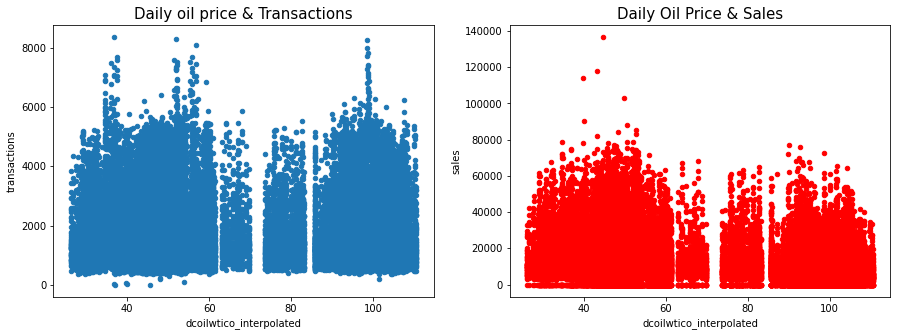

In [ ]:
temp = pd.merge(temp, oil, how = "left") # menggabungnkan dua data frame yaitu temp dan oil
print("Correlation with Daily Oil Prices")
print(temp.drop(["store_nbr", "dcoilwtico"], axis = 1).corr("spearman").dcoilwtico_interpolated.loc[["sales", "transactions"]], "\n")
# mencetak nilai korelasi antara variabel sales dan transaction dengan var. dcoilwtico_interpolated.  kemudian korelasi dihitung dengan menggunakan metode "spearman".

fig, axes = plt.subplots(1, 2, figsize = (15,5)) #Perintah ini membuat objek Figure dan Axes yang akan digunakan untuk menampilkan plot. 
temp.plot.scatter(x = "dcoilwtico_interpolated", y = "transactions", ax=axes[0]) #menampilkan scaterplot, dengan transaction sebagai var. y
temp.plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[1], color = "r") # sma seperti sebelmnya, hanya saja sales sebgai var, y dan ditambahkan warna merah untuk plotnya
axes[0].set_title('Daily oil price & Transactions', fontsize = 15) # menambahkna judul ke objek axes pertama
axes[1].set_title('Daily Oil Price & Sales', fontsize = 15); # sama seperti diatas

# 5. Sales

Tujuan utama kami adalah, memprediksi penjualan toko untuk setiap kelompok produk. Untuk itu, kolom penjualan harus dicermati lebih serius. Kita perlu mempelajari segala sesuatu seperti musiman, tren, anomali, kesamaan dengan deret waktu lainnya, dan sebagainya.


Kode di atas membuat tabel pivot dari data penjualan, diindeks oleh kolom 
"ind", dikelompokkan berdasarkan "store_nbr", dan dengan nilai di kolom "sales". Tabel pivot kemudian dikorelasikan menggunakan metode .corr(), yang menghitung koefisien korelasi Pearson antara penjualan toko yang berbeda.

Variabel mask digunakan untuk membuat matriks segitiga dari satu dan nol, di mana satu-satunya diletakkan di atas diagonal dan nol diletakkan di bawahnya. Mask ini kemudian diterapkan pada tabel pivot menggunakan parameter mask dalam fungsi sns.heatmap(), yang menciptakan visualisasi heatmap dari korelasi. Heatmap kemudian ditampilkan menggunakan fungsi plt.show().

Heatmap yang dihasilkan akan menunjukkan korelasi antara penjualan toko yang berbeda, dengan korelasi yang lebih tinggi diwakili oleh warna yang lebih hangat dan korelasi yang lebih rendah diwakili oleh warna yang lebih dingin. Parameter annot menentukan bahwa nilai harus ditampilkan di heatmap, dan parameter fmt menentukan format untuk menampilkan nilai (dalam hal ini, satu tempat desimal). Parameter square menentukan bahwa heatmap harus berbentuk persegi, dan parameter cbar menentukan apakah atau tidak menampilkan colorbar di sisi heatmap. Parameter judul dan fontsize menentukan judul dan ukuran font untuk heatmap.

In [ ]:
a = train.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
# mengubah index dtaframe train  menjadi kolom date, kmudian mengelompokan data berdasarkan kolom store_bnr, selanjutnya diresample dengan frekuensi harian
px.line(a, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores")
# menampilkan plot garis dari DF a

Saya menyadari beberapa baris yang tidak perlu dalam data saat saya melihat rangkaian waktu toko satu per satu. Jika Anda memilih toko-toko dari atas, beberapa di antaranya tidak ada penjualannya di awal tahun 2013. Saya memutuskan untuk menghapus baris tersebut sebelum toko dibuka. Dalam kode berikut, kami akan menyingkirkannya.


In [ ]:
print(train.shape)
train = train[~((train.store_nbr == 52) & (train.date < "2017-04-20"))]
train = train[~((train.store_nbr == 22) & (train.date < "2015-10-09"))]
train = train[~((train.store_nbr == 42) & (train.date < "2015-08-21"))]
train = train[~((train.store_nbr == 21) & (train.date < "2015-07-24"))]
train = train[~((train.store_nbr == 29) & (train.date < "2015-03-20"))]
train = train[~((train.store_nbr == 20) & (train.date < "2015-02-13"))]
train = train[~((train.store_nbr == 53) & (train.date < "2014-05-29"))]
train = train[~((train.store_nbr == 36) & (train.date < "2013-05-09"))]
train.shape

(3000888, 6)


(2780316, 6)

In [ ]:
a = train.set_index("date").groupby("family").resample("D").sales.sum().reset_index()
#ubah indeex jadi date, kemudian diresamplle dalam bentuk harian
px.line(a, x = "date", y= "sales", color = "family", title = "Daily total sales of the family")
#membuat pllot

Kami bekerja dengan toko-toko. Nah, ada banyak produk di toko-toko dan kita perlu tahu keluarga produk mana yang lebih banyak terjual? Mari kita buat barplot untuk melihatnya.

Grafik menunjukkan kepada kita GROCERY I dan BEVERAGES adalah keluarga terlaris.

In [ ]:
a = train.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
# mengelompokkan data di DF train berdasarkaan kolom family, lalu menghitung rata2 kolom sales, kmudian hasilnya diurutkan dari yang terendah
px.bar(a, y = "family", x="sales", color = "family", title = "Which product family preferred more?")
# membuat plot batang 

In [ ]:
print("Spearman Correlation between Sales and Onpromotion: {:,.4f}".format(train.corr("spearman").sales.loc["onpromotion"]))
# mencetak nilai korelasi spearman antara variabel "sales" dan "onpromotion" pada data "train"
# Spearman adalah ukuran korelasi yang mengukur kekuatan dan arah hubungan antara dua variabel pengukuran ordinal atau skala ordinal. 

Spearman Correlation between Sales and Onpromotion: 0.5304




---



In [ ]:
a = d[d.year.isin([2016,2017])].groupby(["year", "day_of_year"]).sales.mean().reset_index()
px.line(a, x = "day_of_year", y = "sales", color = "year", title = "Average sales for 2016 and 2017")

Kode program di atas akan menampilkan plot garis yang menunjukkan rata-rata penjualan setiap hari dalam tahun untuk tahun 2016 dan 2017. Pertama-tama, dataframe dikelompokkan berdasarkan tahun dan hari dalam tahun, dan rata-rata penjualan dihitung untuk setiap kelompok. Dataframe yang dihasilkan kemudian di-reset indeksnya dan disimpan ke dalam variabel "a".

Kemudian, plot garis dihasilkan dengan menggunakan library plotly. Data yang digunakan adalah variabel "a", dengan kolom "day_of_year" sebagai koordinat x dan kolom "sales" sebagai koordinat y. Warna dari setiap garis akan berbeda berdasarkan tahun yang sedang dianalisis, dengan tahun 2016 ditampilkan dengan warna biru dan tahun 2017 ditampilkan dengan warna hijau. Judul dari plot akan menjadi "Average sales for 2016 and 2017".





In [ ]:
a = train.sort_values(["store_nbr", "family", "date"])
for i in [20, 30, 45, 60, 90, 120, 365, 730]:
    a["SMA"+str(i)+"_sales_lag16"] = a.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(16).values
    a["SMA"+str(i)+"_sales_lag30"] = a.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(30).values
    a["SMA"+str(i)+"_sales_lag60"] = a.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(60).values
print("Correlation")
a[["sales"]+a.columns[a.columns.str.startswith("SMA")].tolist()].corr()

Correlation


sales  SMA20_sales_lag16  SMA20_sales_lag30  \
sales                1.00               0.91               0.89   
SMA20_sales_lag16    0.91               1.00               0.99   
SMA20_sales_lag30    0.89               0.99               1.00   
SMA20_sales_lag60    0.87               0.95               0.96   
SMA30_sales_lag16    0.91               1.00               0.99   
SMA30_sales_lag30    0.89               0.98               1.00   
SMA30_sales_lag60    0.87               0.95               0.96   
SMA45_sales_lag16    0.91               0.99               1.00   
SMA45_sales_lag30    0.90               0.98               0.99   
SMA45_sales_lag60    0.87               0.95               0.97   
SMA60_sales_lag16    0.91               0.99               0.99   
SMA60_sales_lag30    0.89               0.98               0.99   
SMA60_sales_lag60    0.87               0.95               0.97   
SMA90_sales_lag16    0.91               0.99               0.99   
SMA90_sales_lag30    0.89               0.98               0.99   
SMA90_sales_lag60    0.87               0.95               0.96   
SMA120_sales_lag16   0.90               0.98               0.99   
SMA120_sales_lag30   0.89               0.97               0.98   
SMA120_sales_lag60   0.86               0.95               0.96   
SMA365_sales_lag16   0.90               0.97               0.97   
SMA365_sales_lag30   0.89               0.97               0.97   
SMA365_sales_lag60   0.87               0.95               0.96   
SMA730_sales_lag16   0.91               0.98               0.98   
SMA730_sales_lag30   0.89               0.98               0.98   
SMA730_sales_lag60   0.86               0.95               0.96   

                    SMA20_sales_lag60  SMA30_sales_lag16  SMA30_sales_lag30  \
sales                            0.87               0.91               0.89   
SMA20_sales_lag16                0.95               1.00               0.98   
SMA20_sales_lag30                0.96               0.99               1.00   
SMA20_sales_lag60                1.00               0.96               0.98   
SMA30_sales_lag16                0.96               1.00               0.99   
SMA30_sales_lag30                0.98               0.99               1.00   
SMA30_sales_lag60                1.00               0.96               0.98   
SMA45_sales_lag16                0.98               1.00               1.00   
SMA45_sales_lag30                0.99               0.99               1.00   
SMA45_sales_lag60                0.99               0.96               0.98   
SMA60_sales_lag16                0.99               0.99               1.00   
SMA60_sales_lag30                0.99               0.99               0.99   
SMA60_sales_lag60                0.99               0.96               0.98   
SMA90_sales_lag16                0.99               0.99               0.99   
SMA90_sales_lag30                0.99               0.98               0.99   
SMA90_sales_lag60                0.99               0.96               0.97   
SMA120_sales_lag16               0.99               0.99               0.99   
SMA120_sales_lag30               0.99               0.98               0.99   
SMA120_sales_lag60               0.98               0.96               0.97   
SMA365_sales_lag16               0.98               0.98               0.98   
SMA365_sales_lag30               0.97               0.97               0.98   
SMA365_sales_lag60               0.97               0.96               0.97   
SMA730_sales_lag16               0.98               0.98               0.98   
SMA730_sales_lag30               0.98               0.98               0.98   
SMA730_sales_lag60               0.98               0.96               0.98   

                    SMA30_sales_lag60  SMA45_sales_lag16  SMA45_sales_lag30  \
sales                            0.87               0.91               0.90   
SMA20_sales_lag16                0.95               0.99        

Ini adalah kode yang menambahkan beberapa kolom baru ke dataframe a yang diurutkan berdasarkan store_nbr, family, dan date. Kolom-kolom baru tersebut berisi moving average dengan periode 20 hari, 30 hari, 45 hari, 60 hari, 90 hari, 120 hari, 365 hari, dan 730 hari. Kolom-kolom tersebut juga dilag dengan nilai 16, 30, dan 60 hari. Setelah menambahkan kolom-kolom baru, kode mencetak "Correlation" dan kemudian menghitung korelasi antara kolom sales dan kolom-kolom baru yang dimulai dengan "SMA" (moving average). Hasil korelasi tersebut ditampilkan ke layar.

FORECASTING

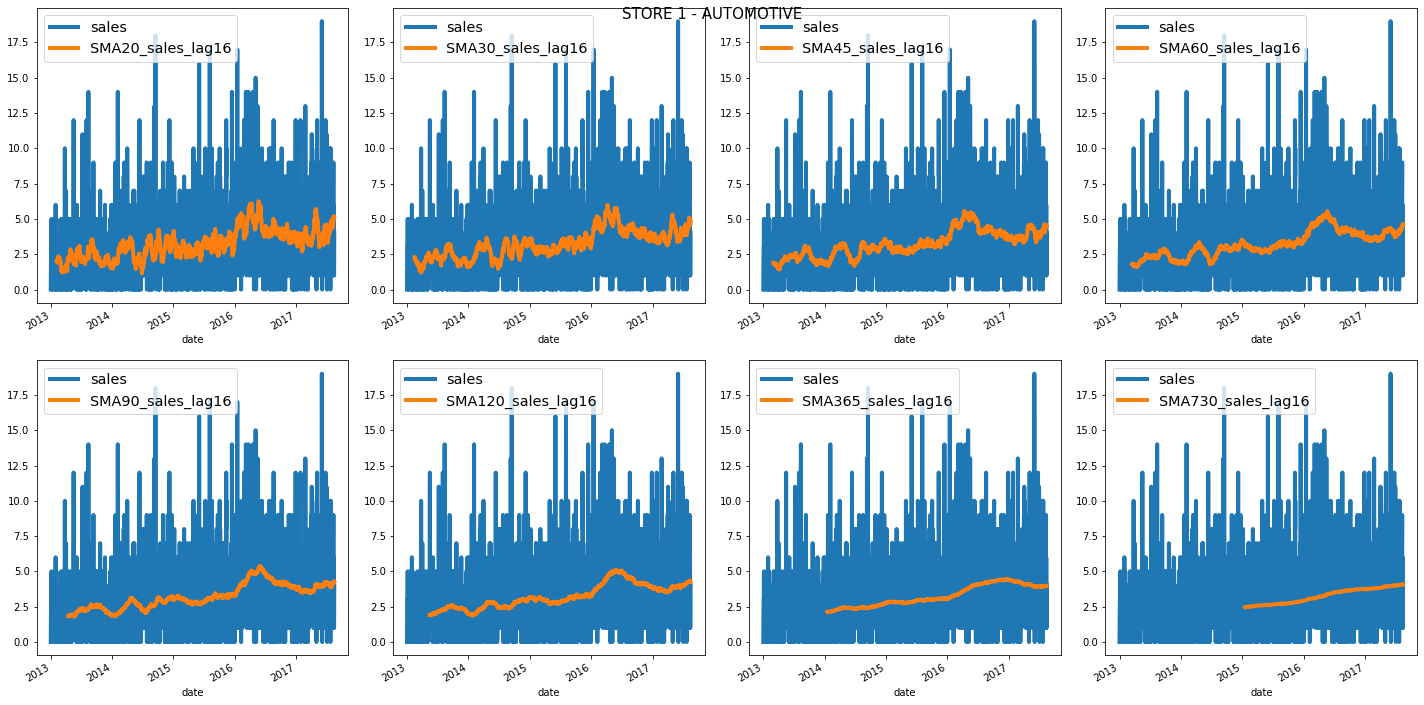

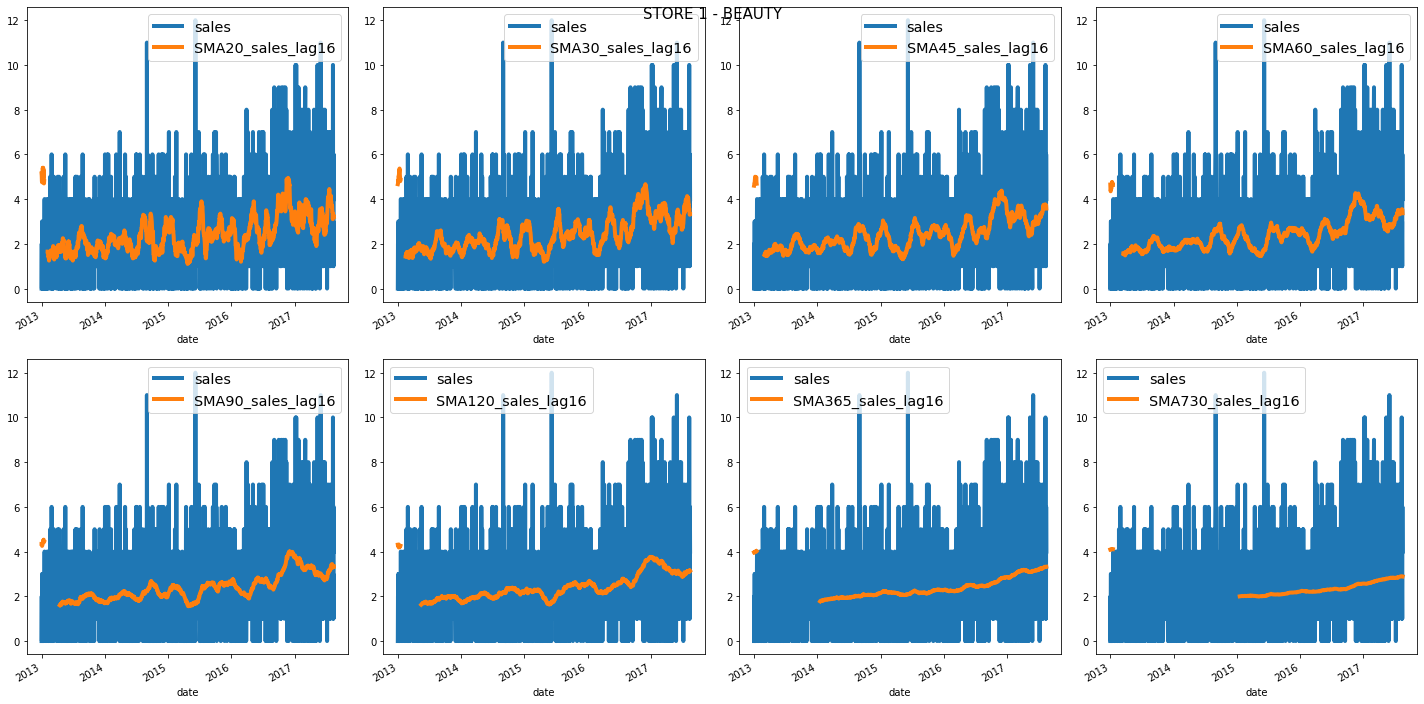

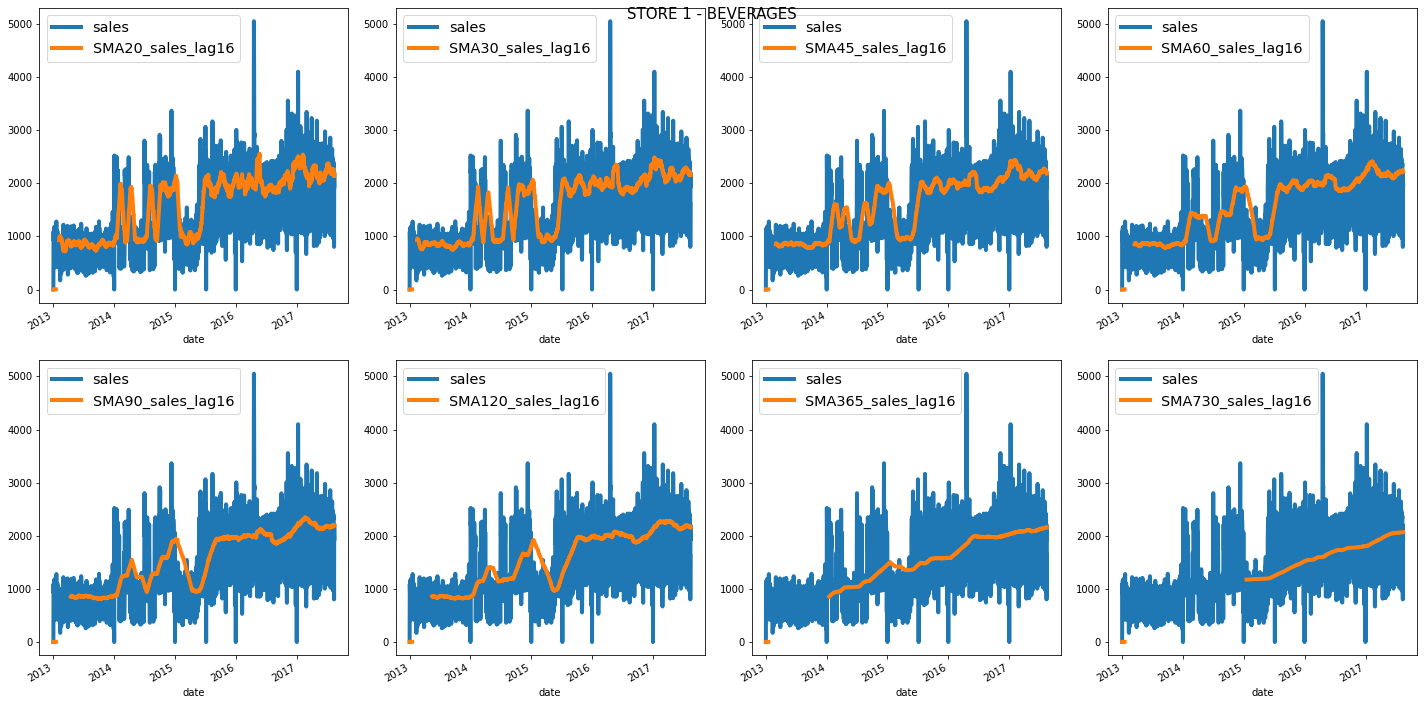

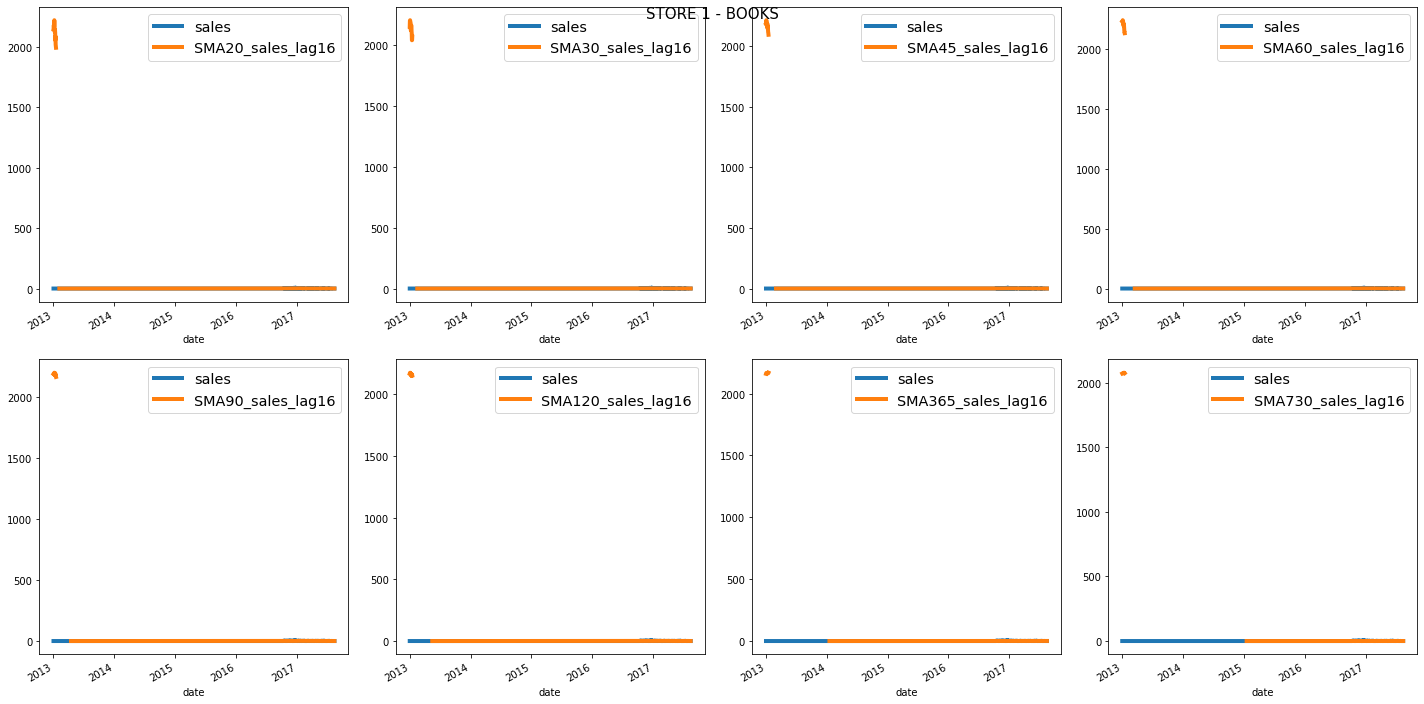

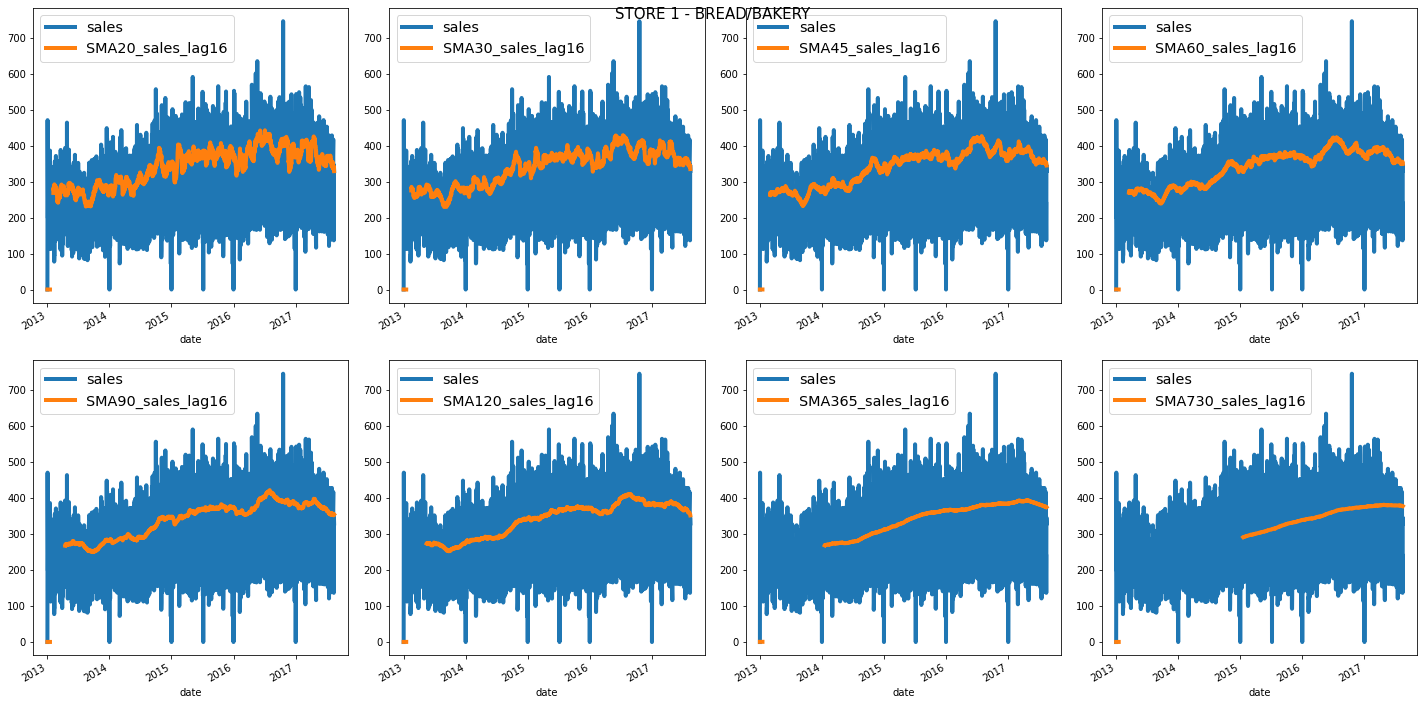

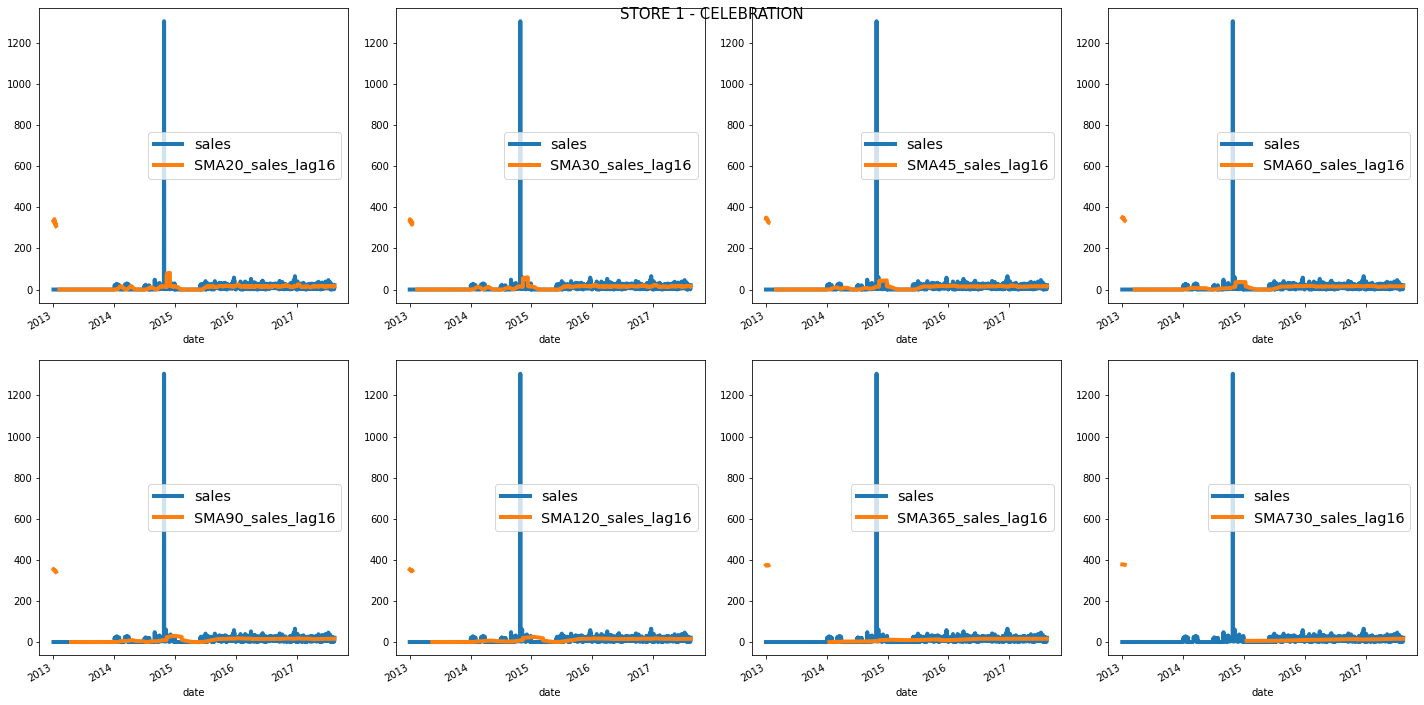

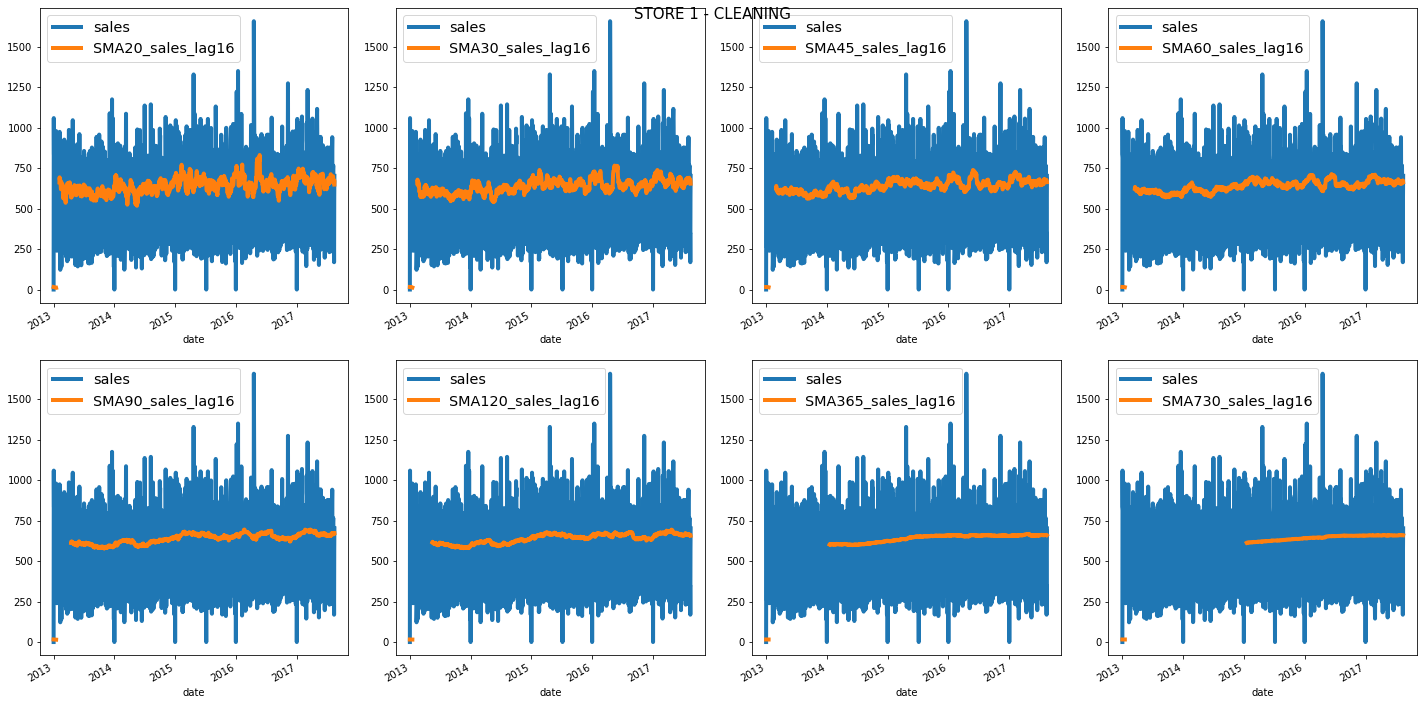

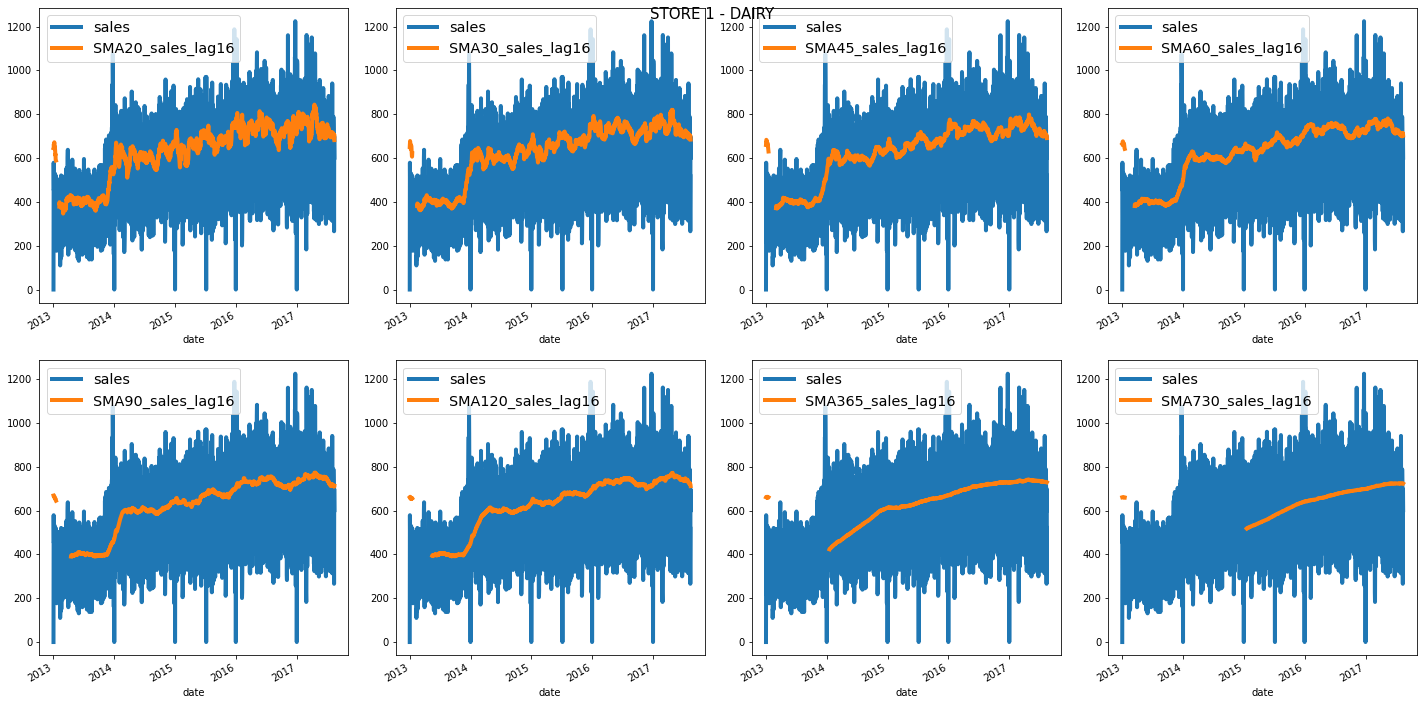

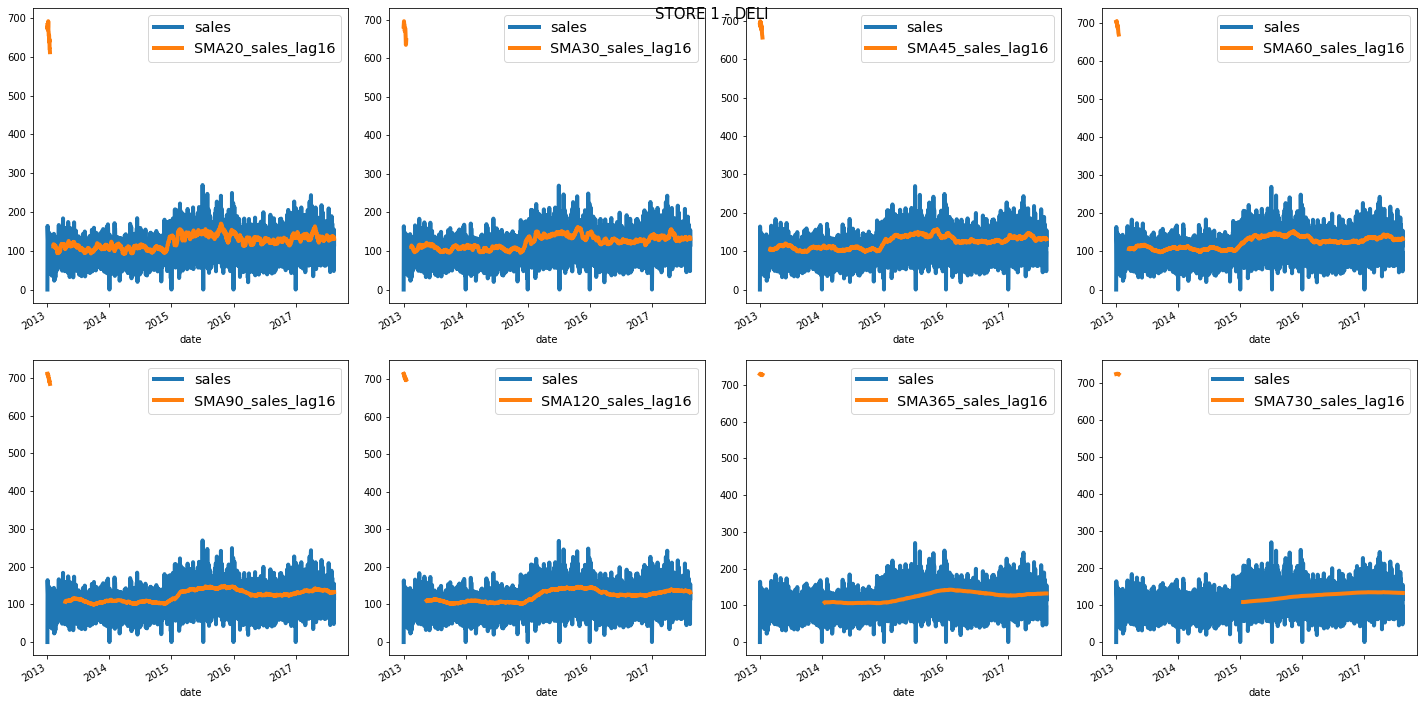

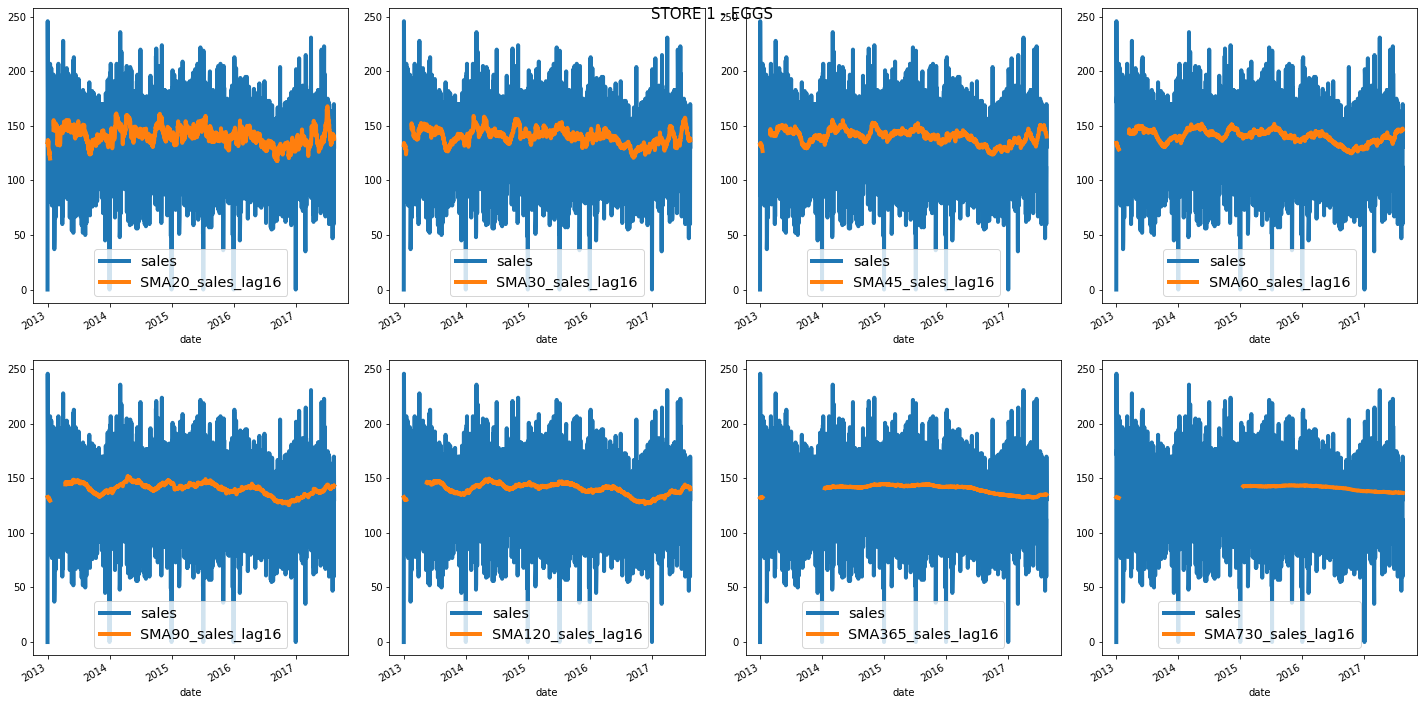

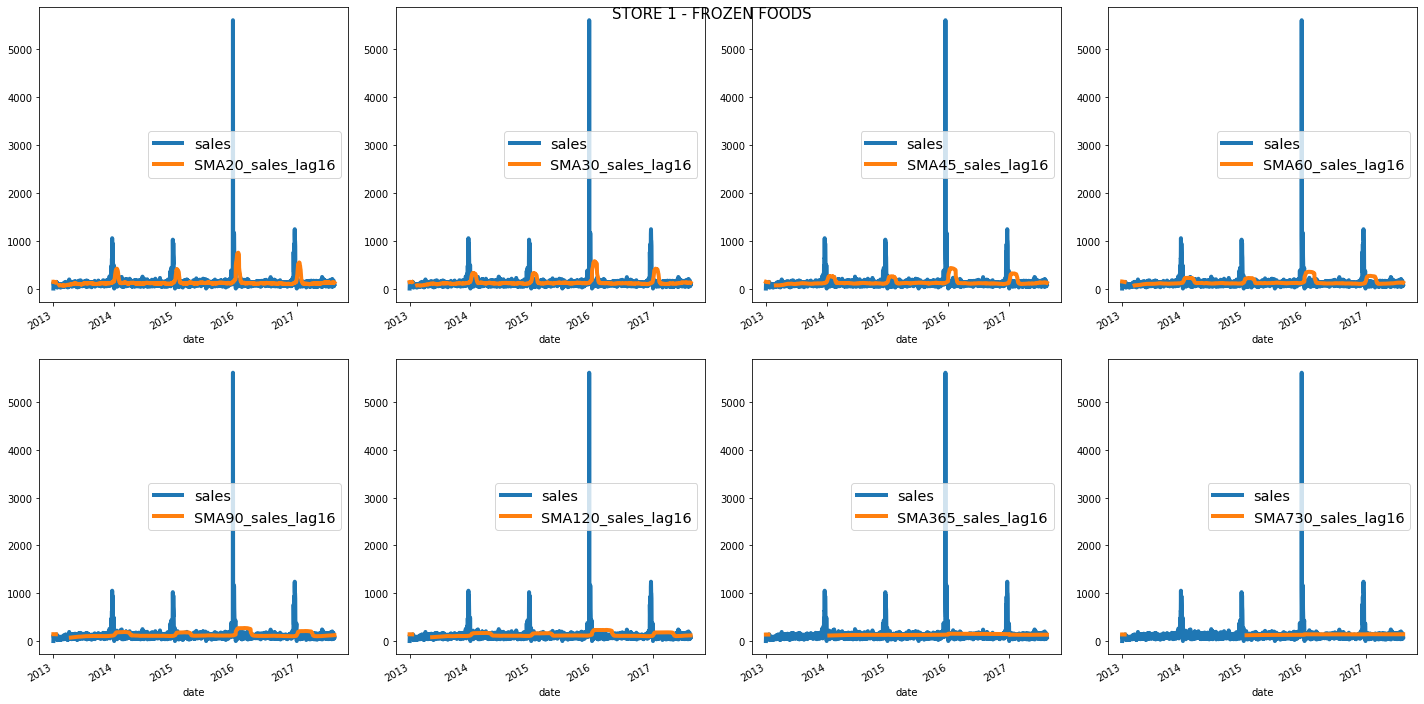

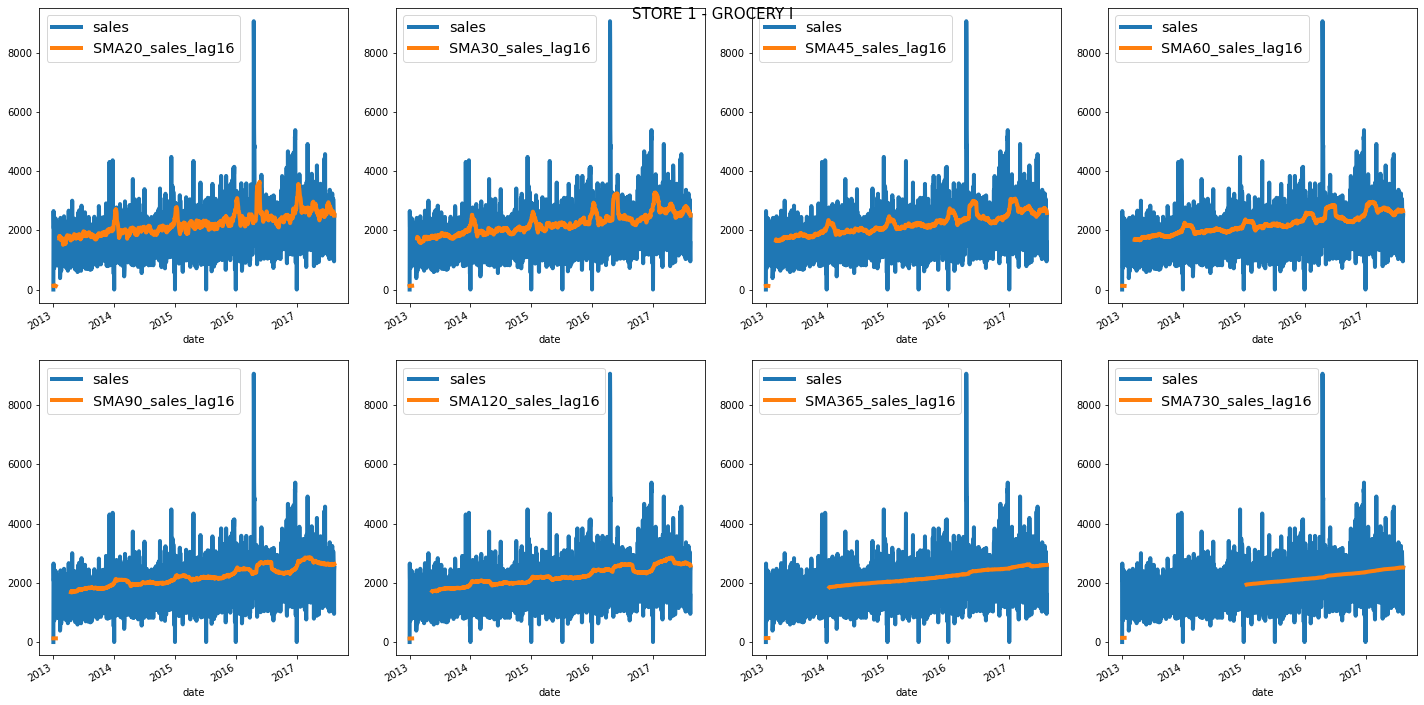

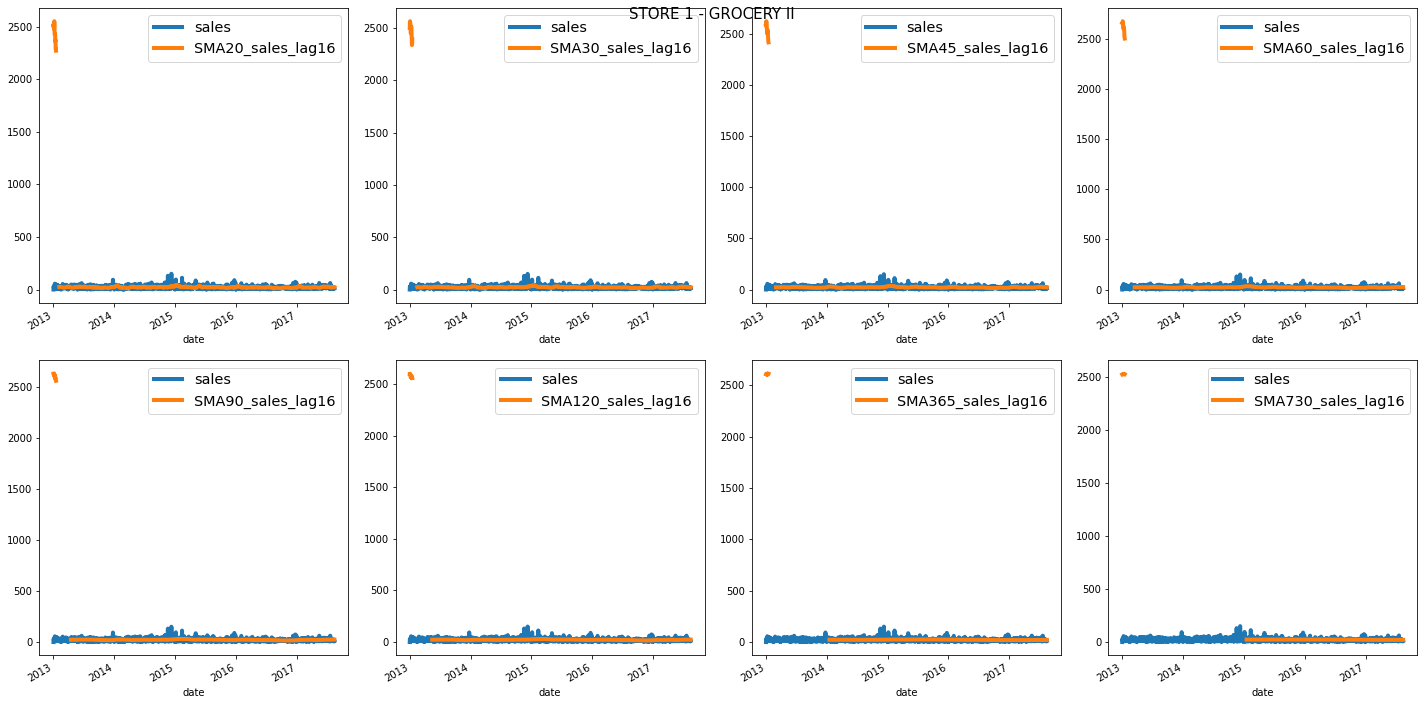

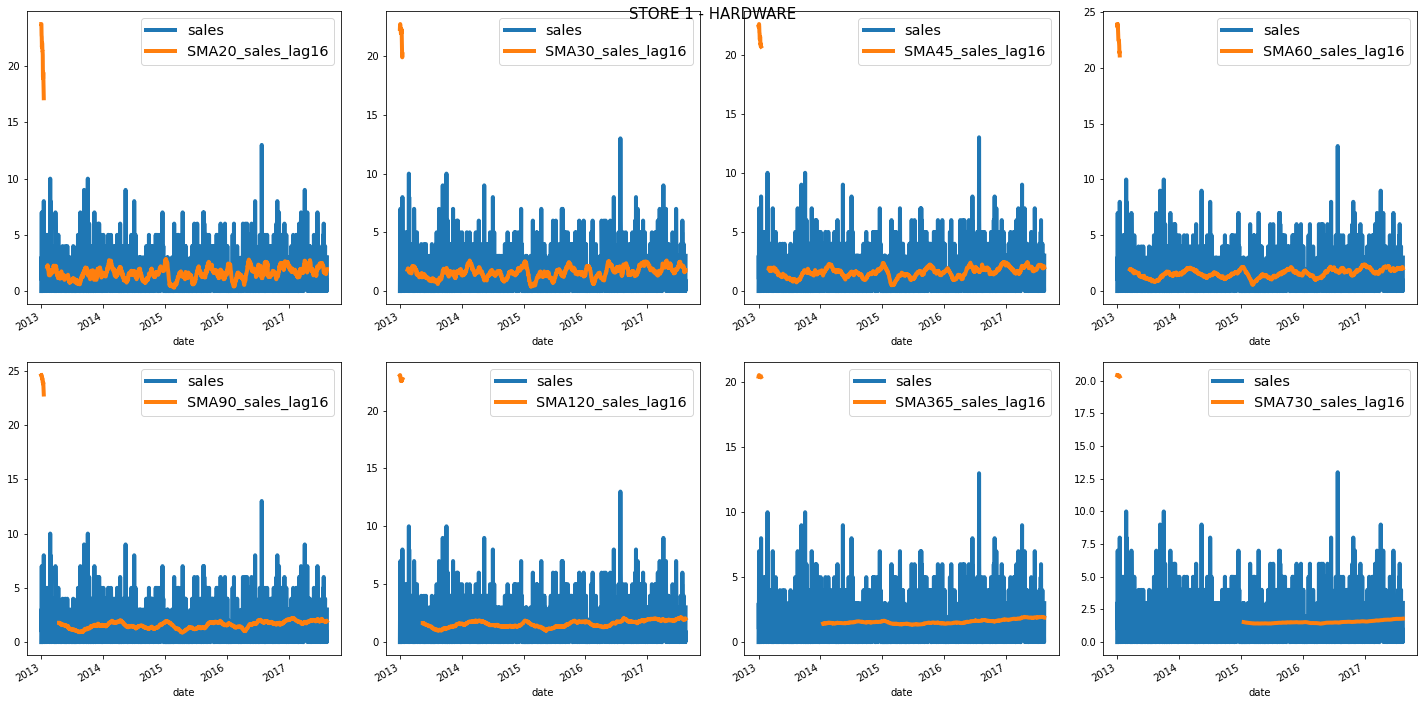

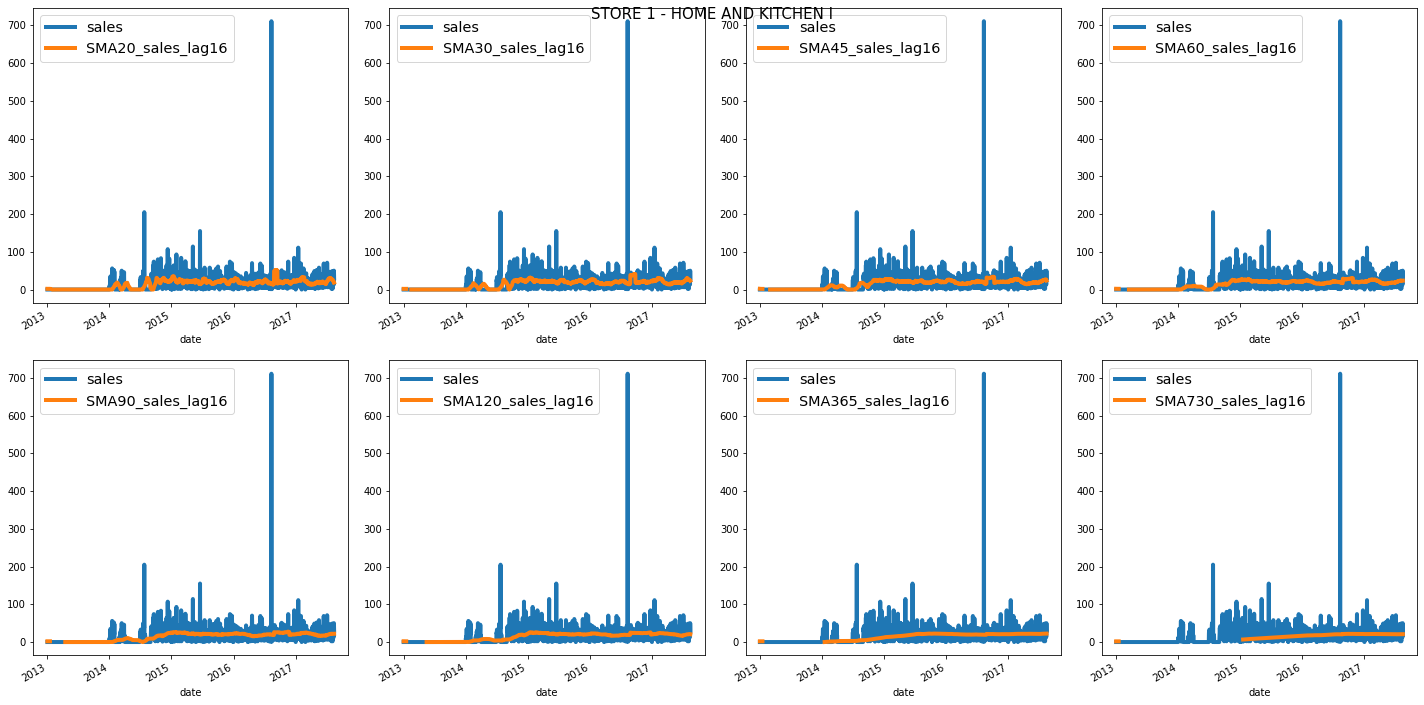

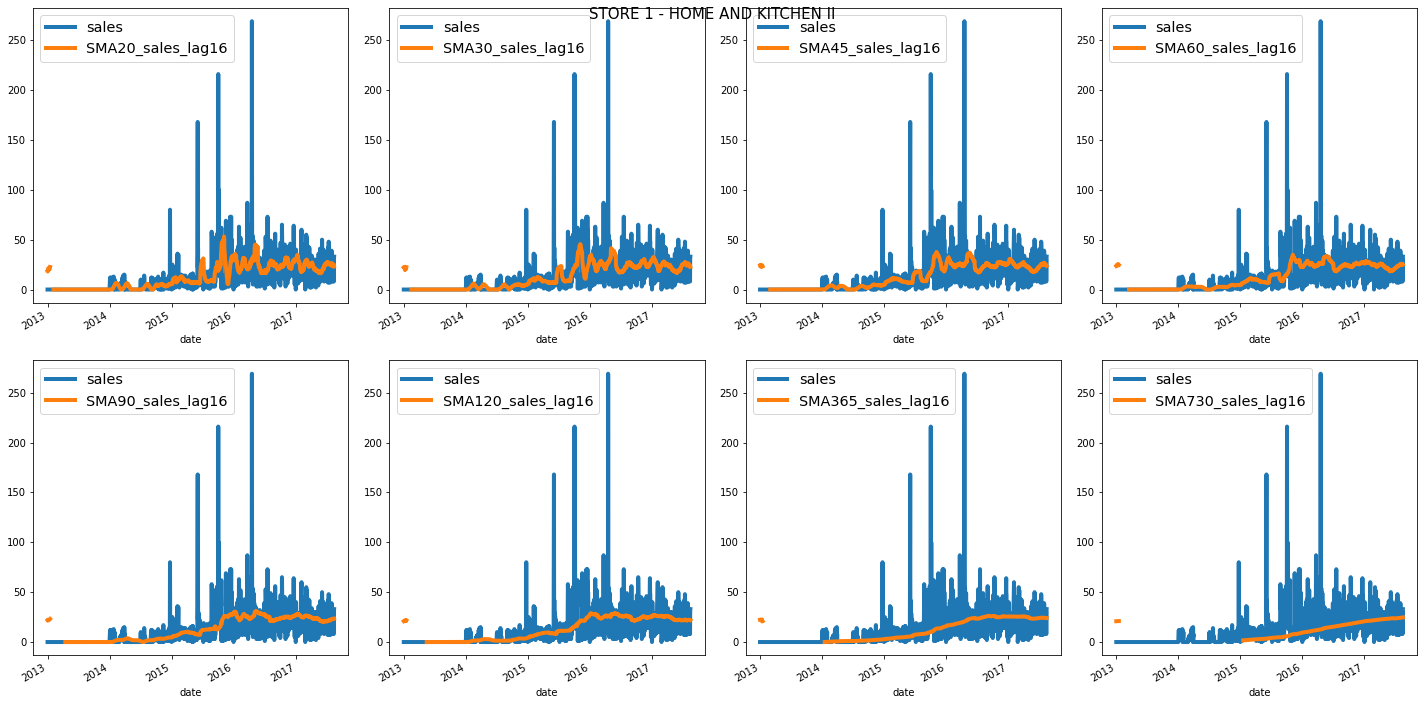

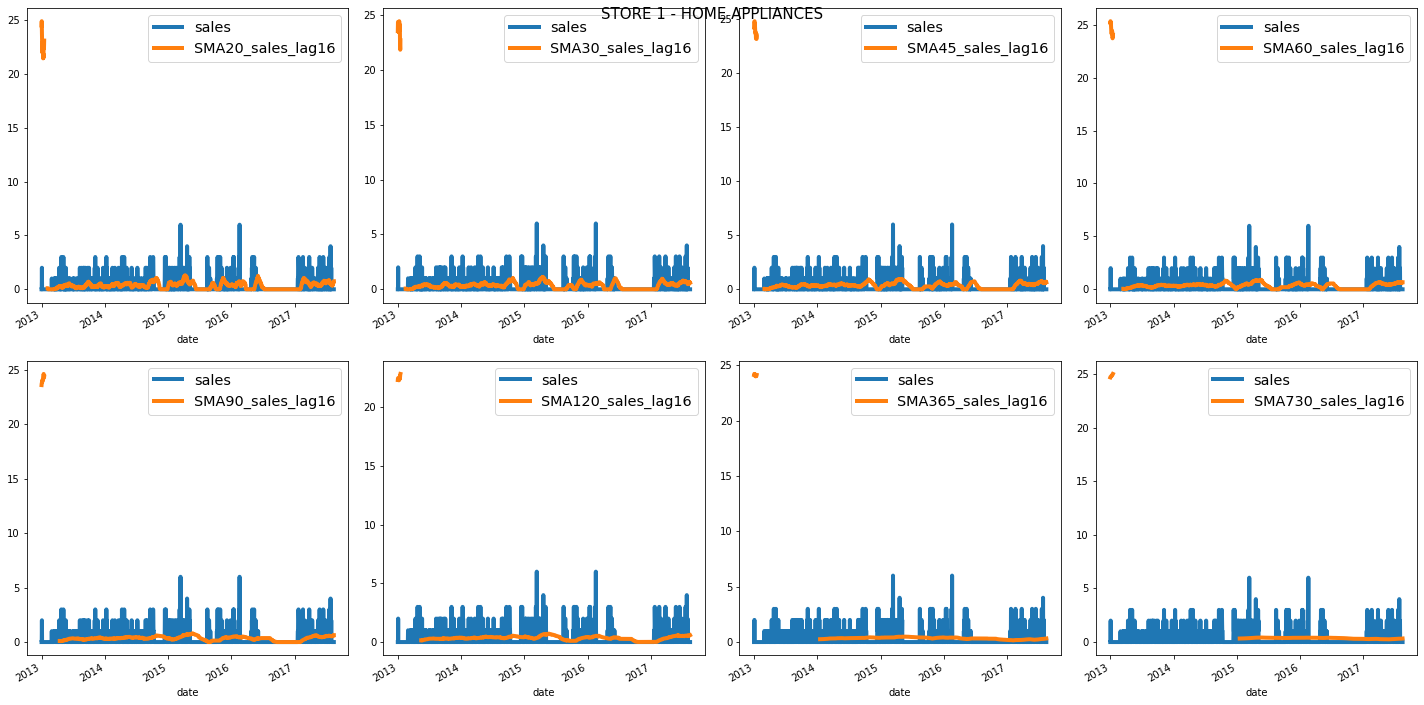

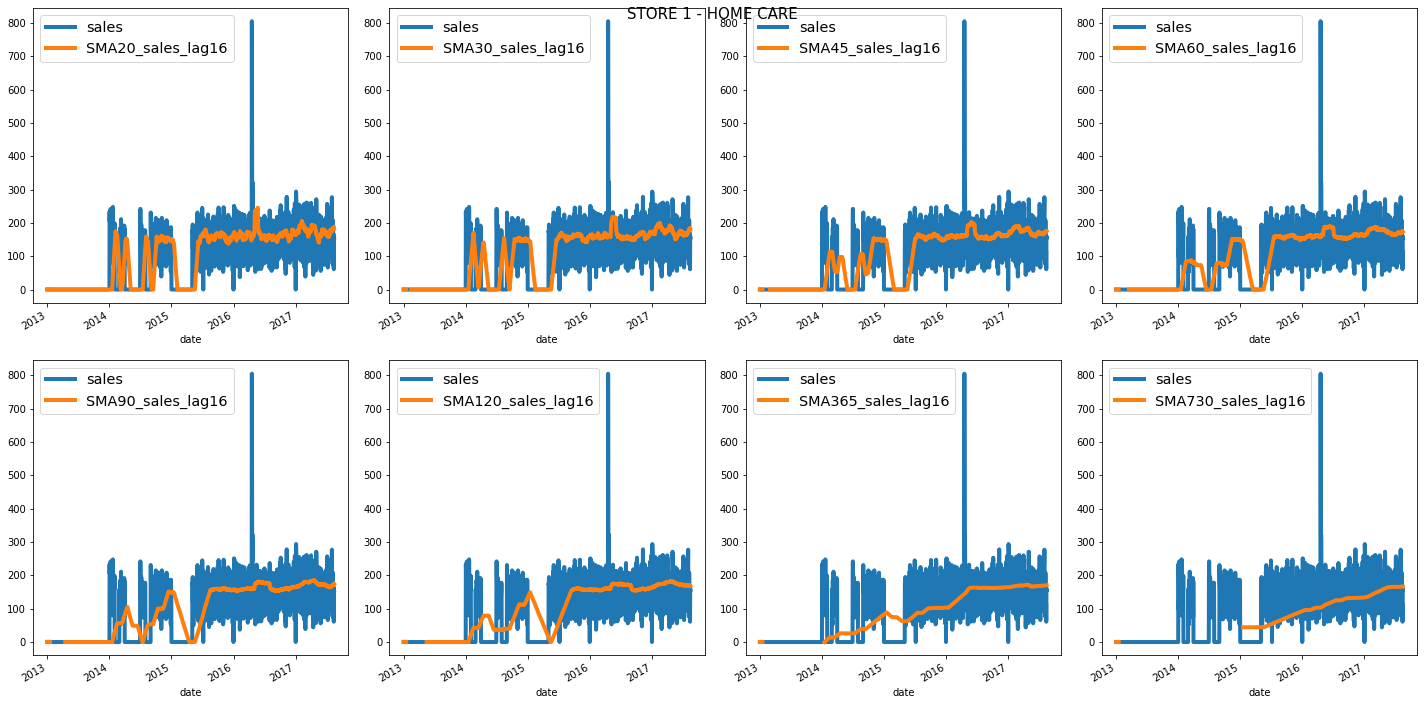

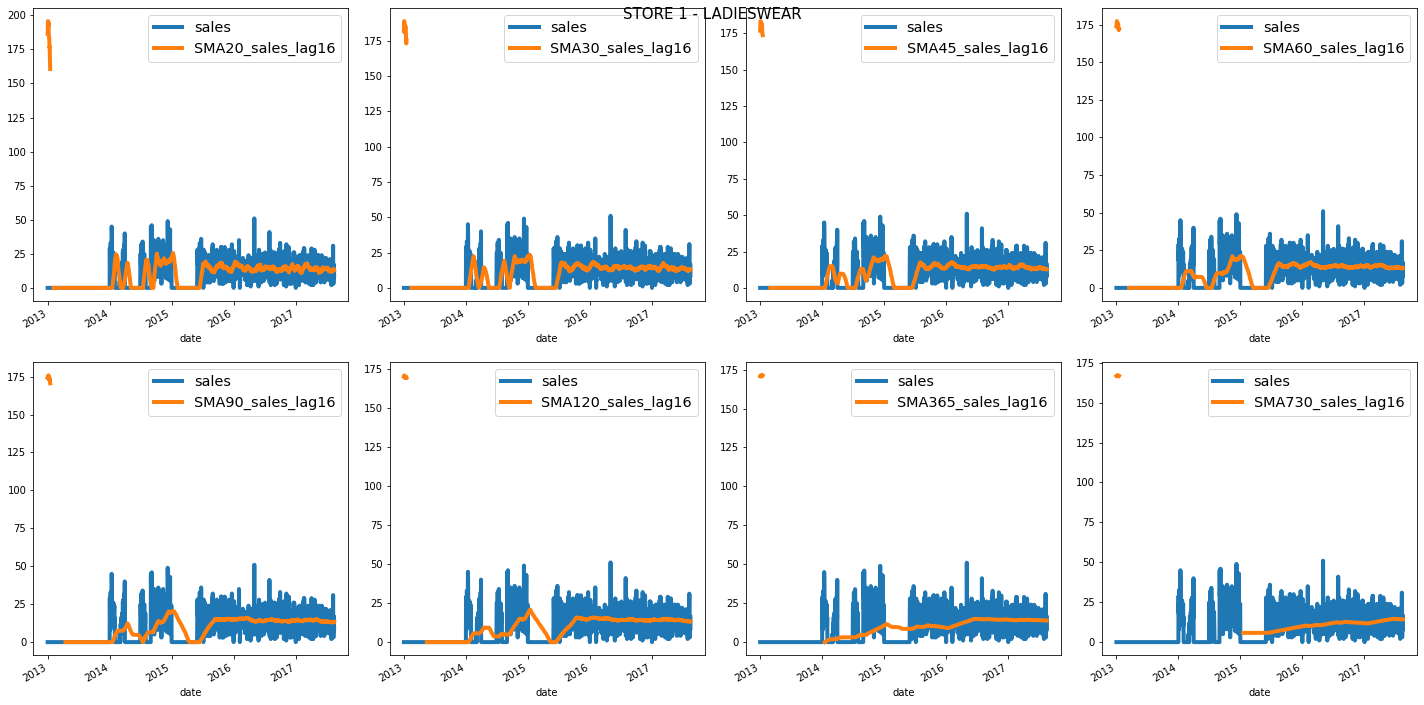

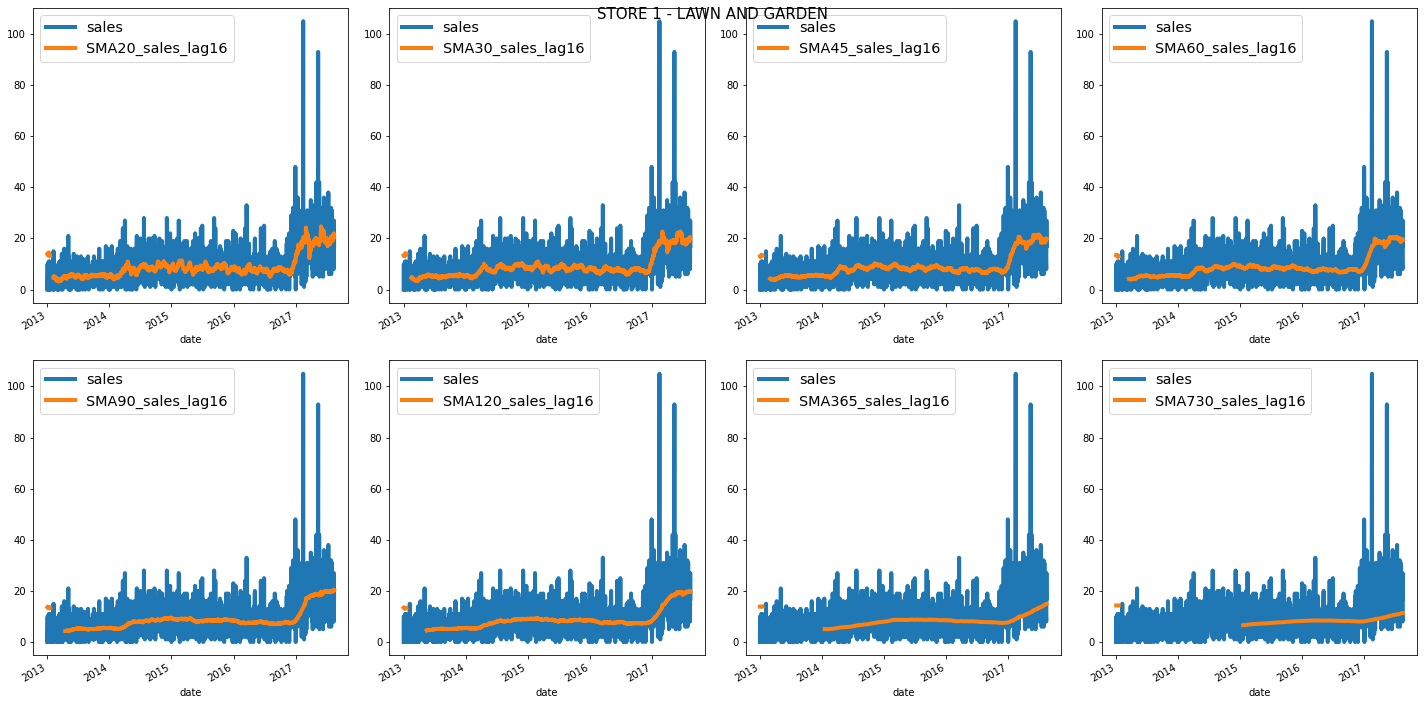

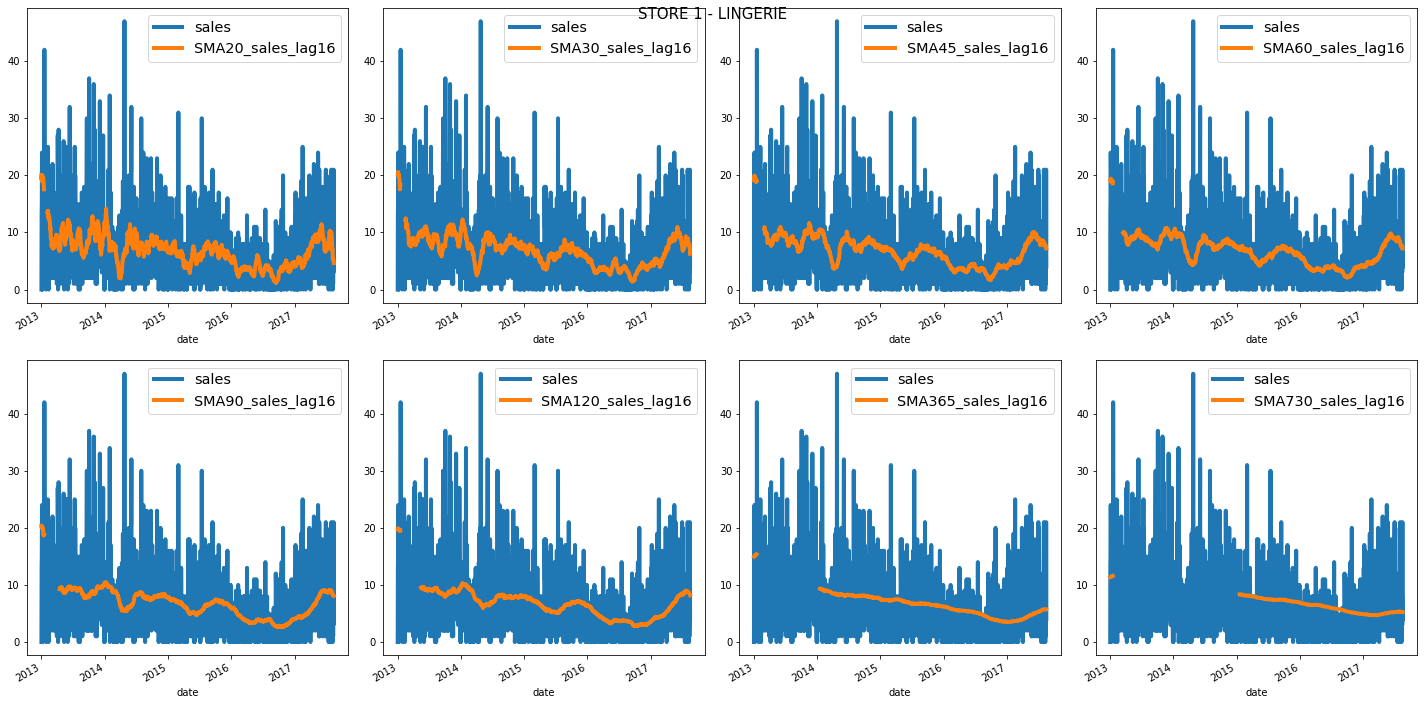

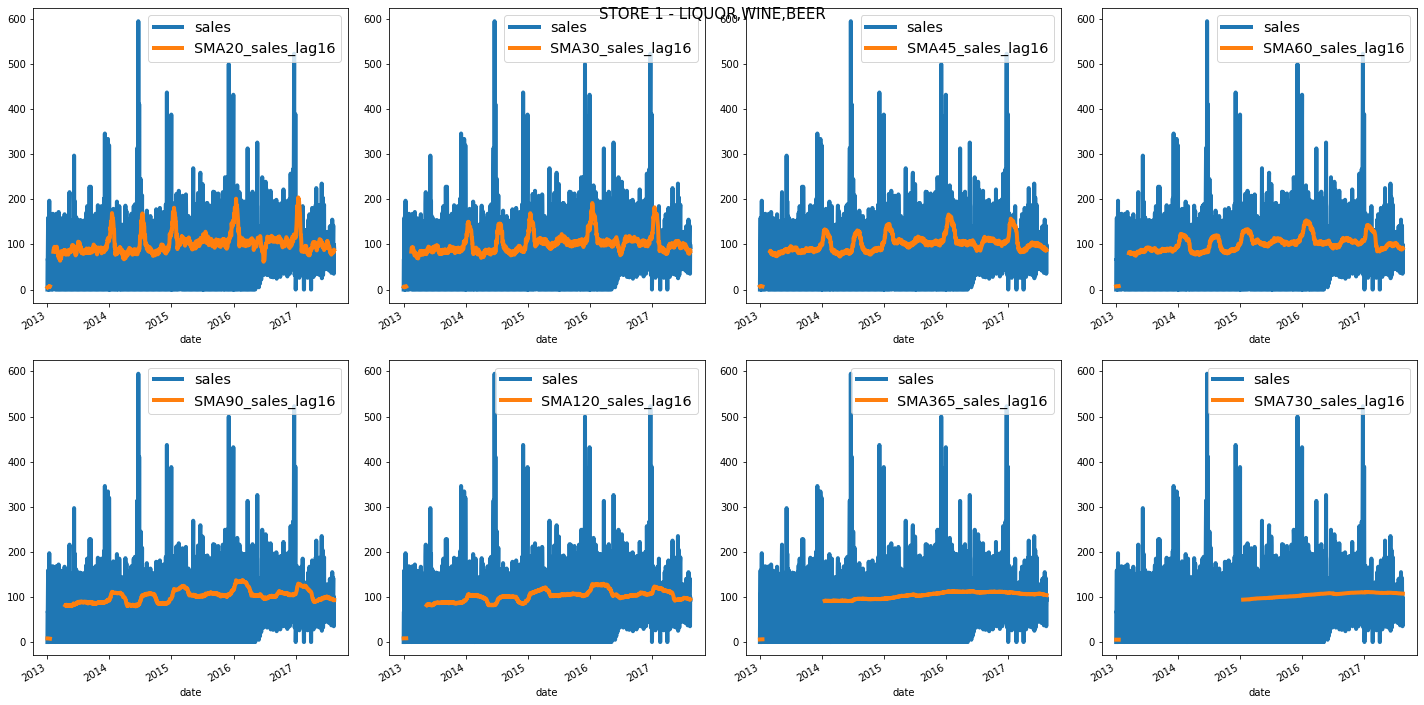

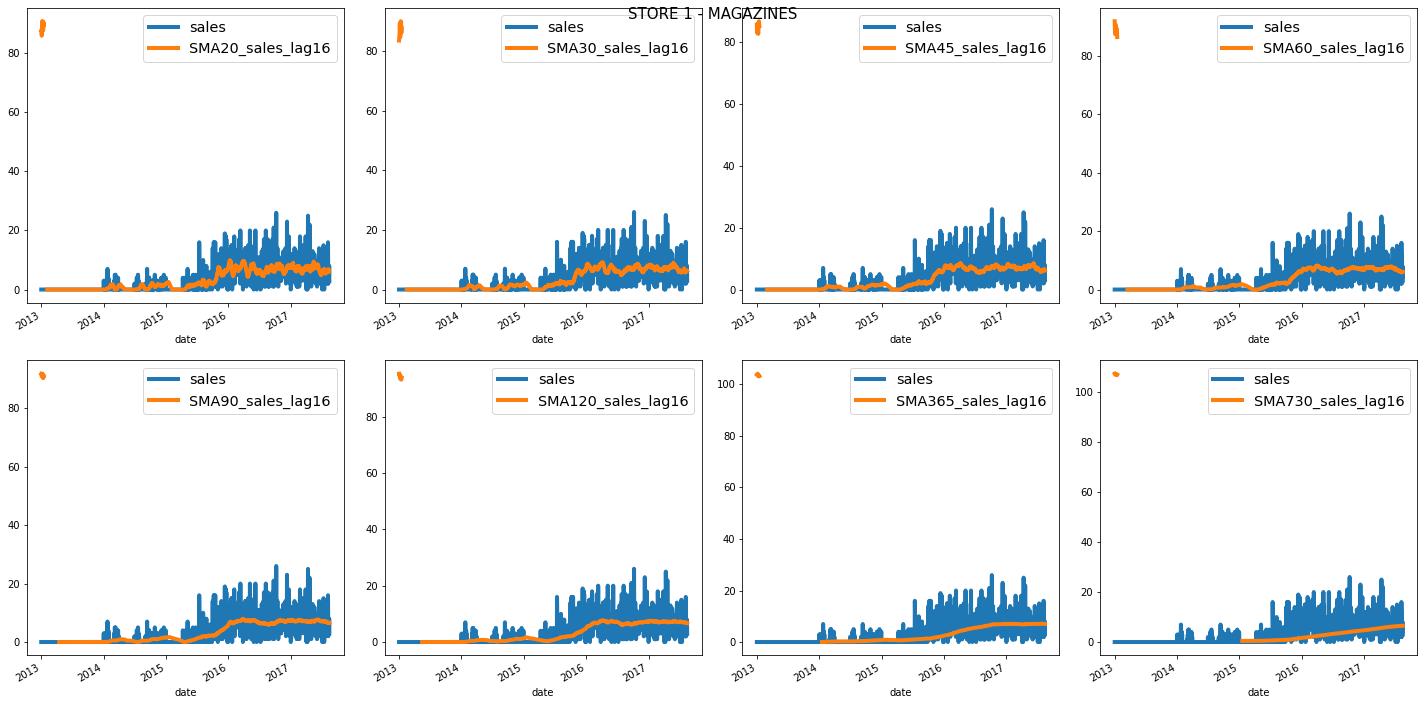

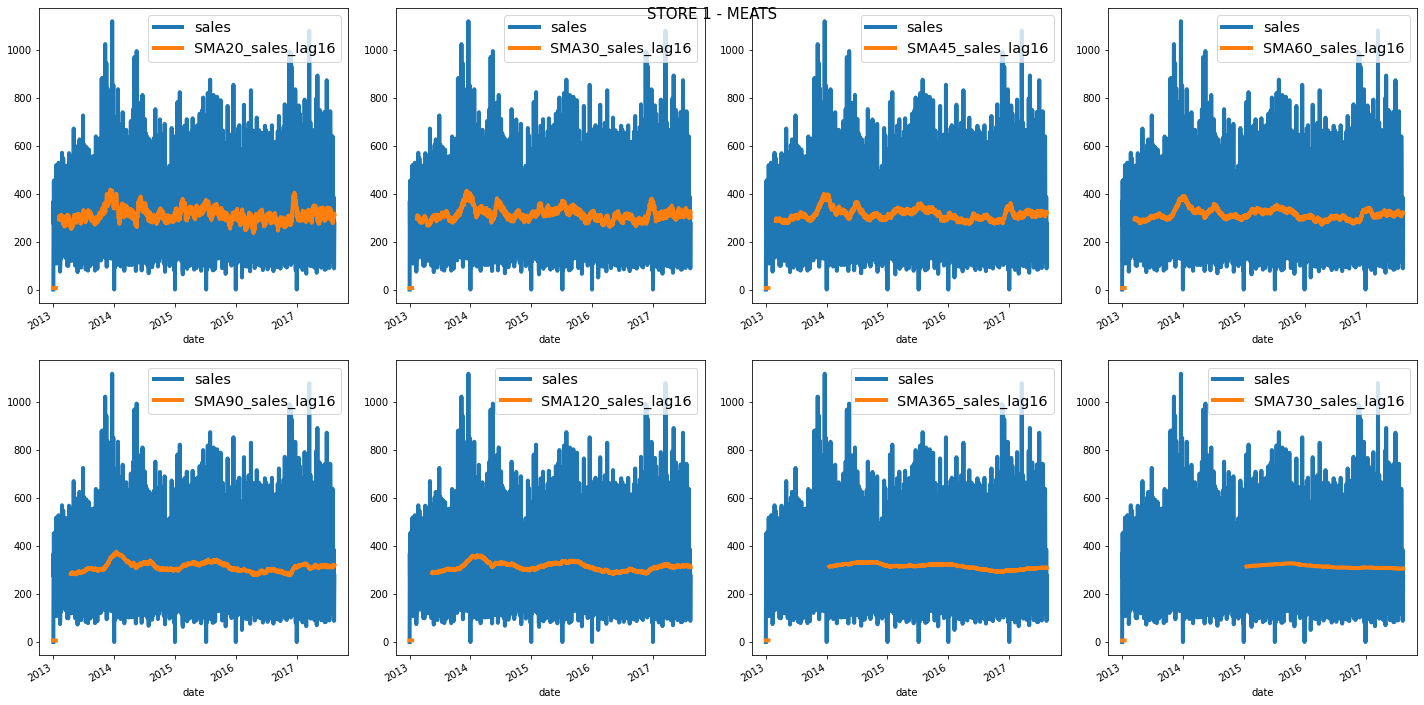

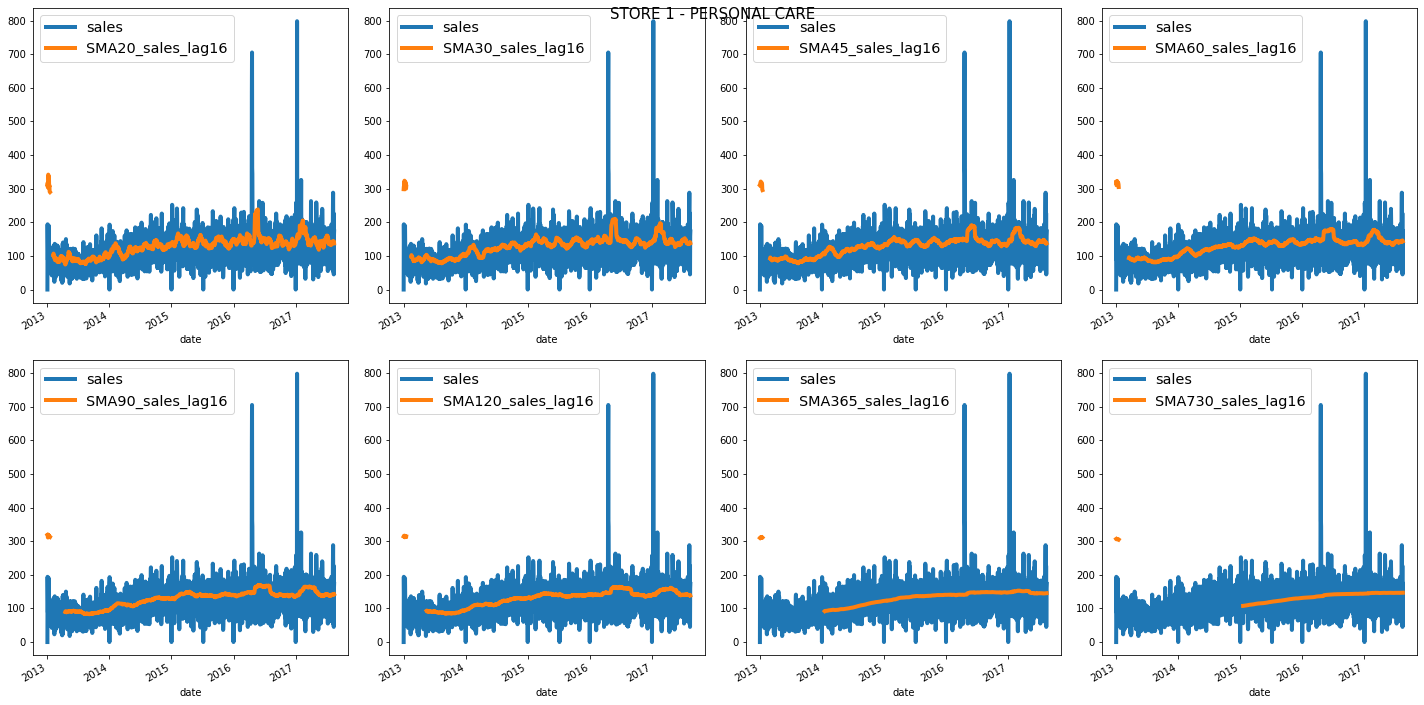

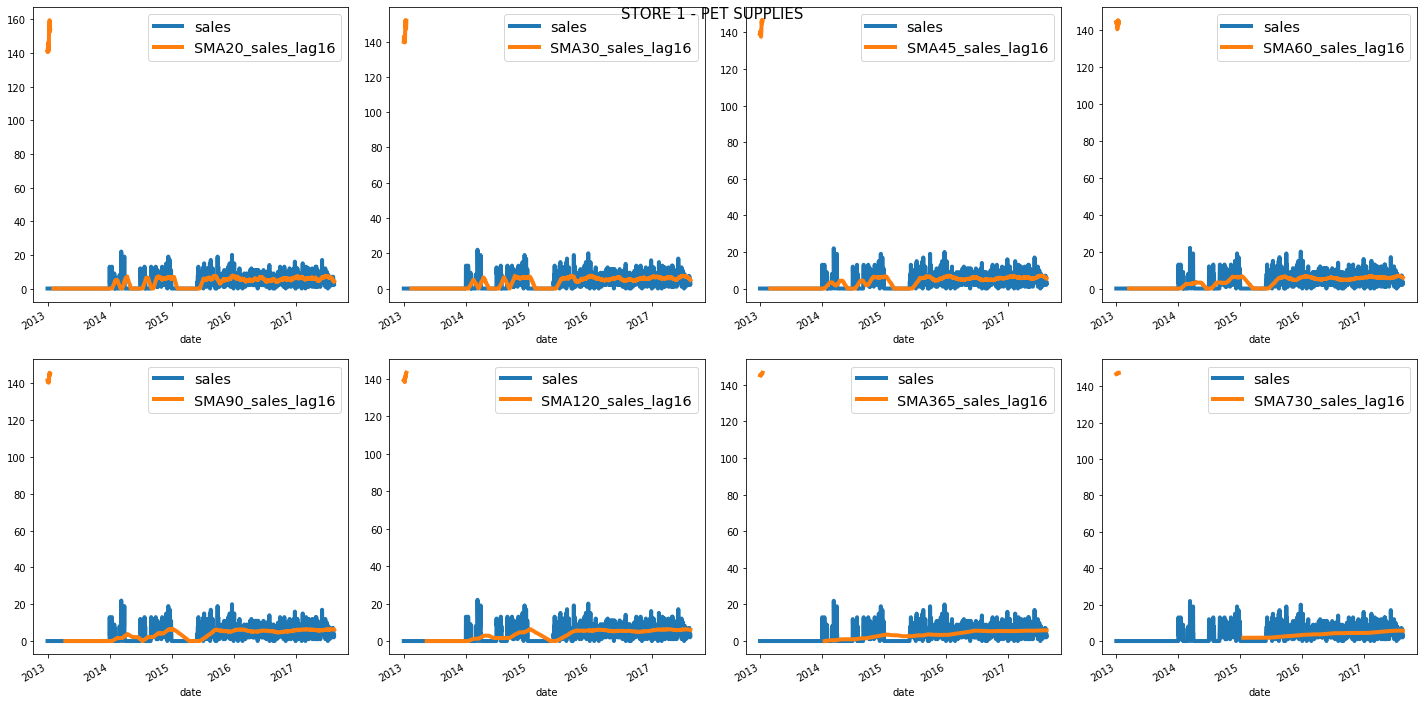

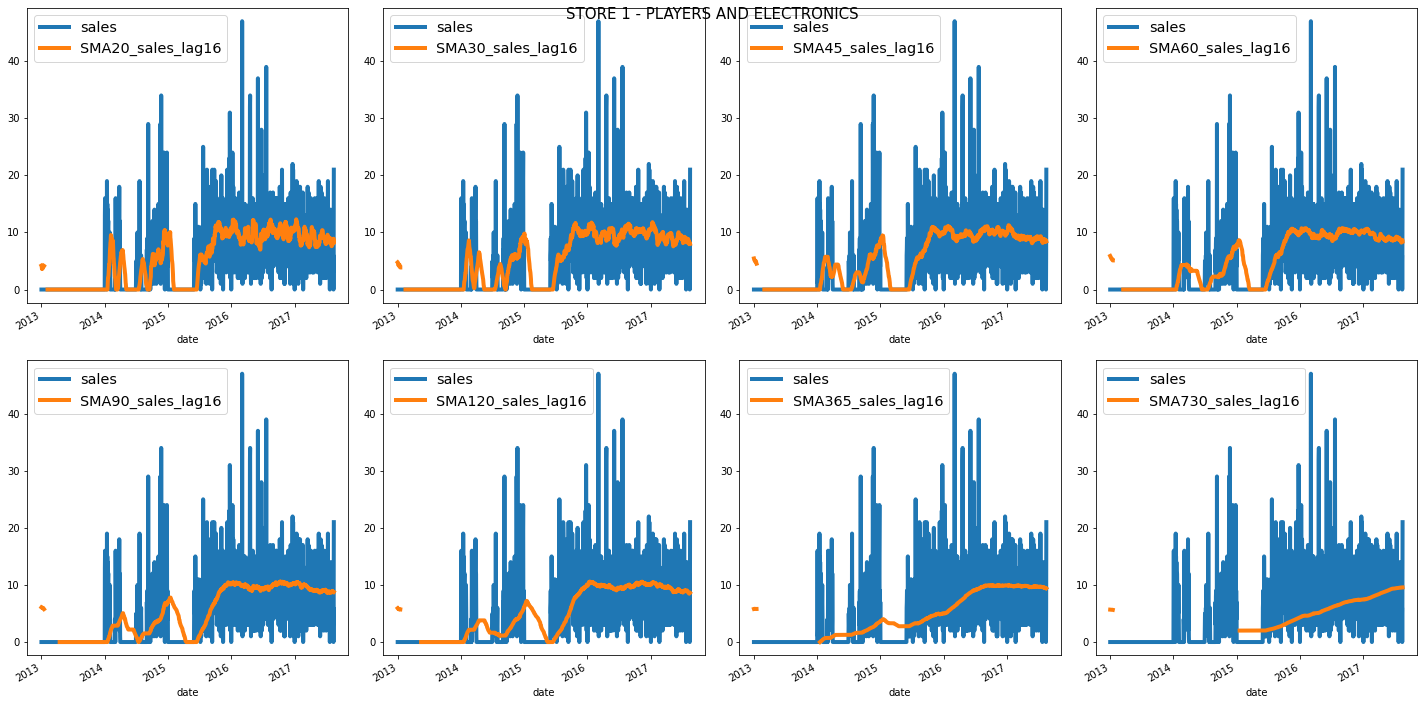

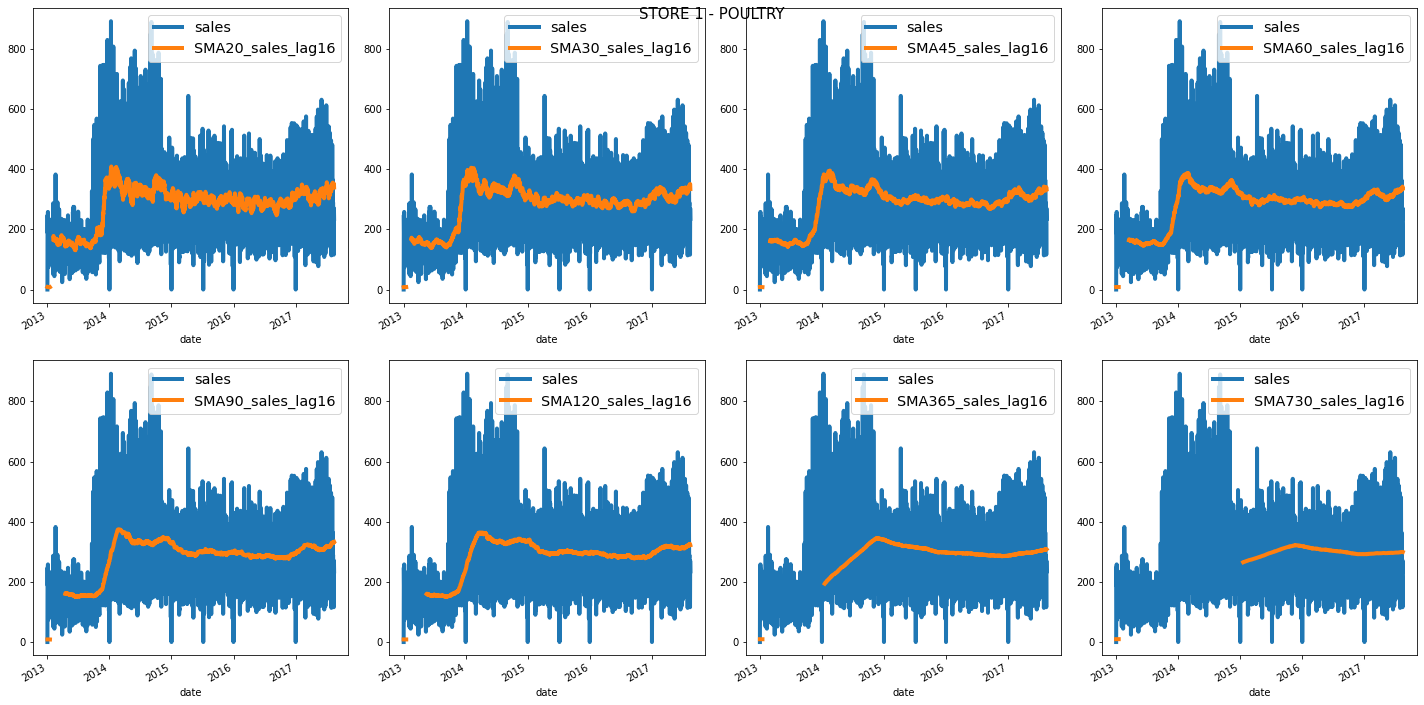

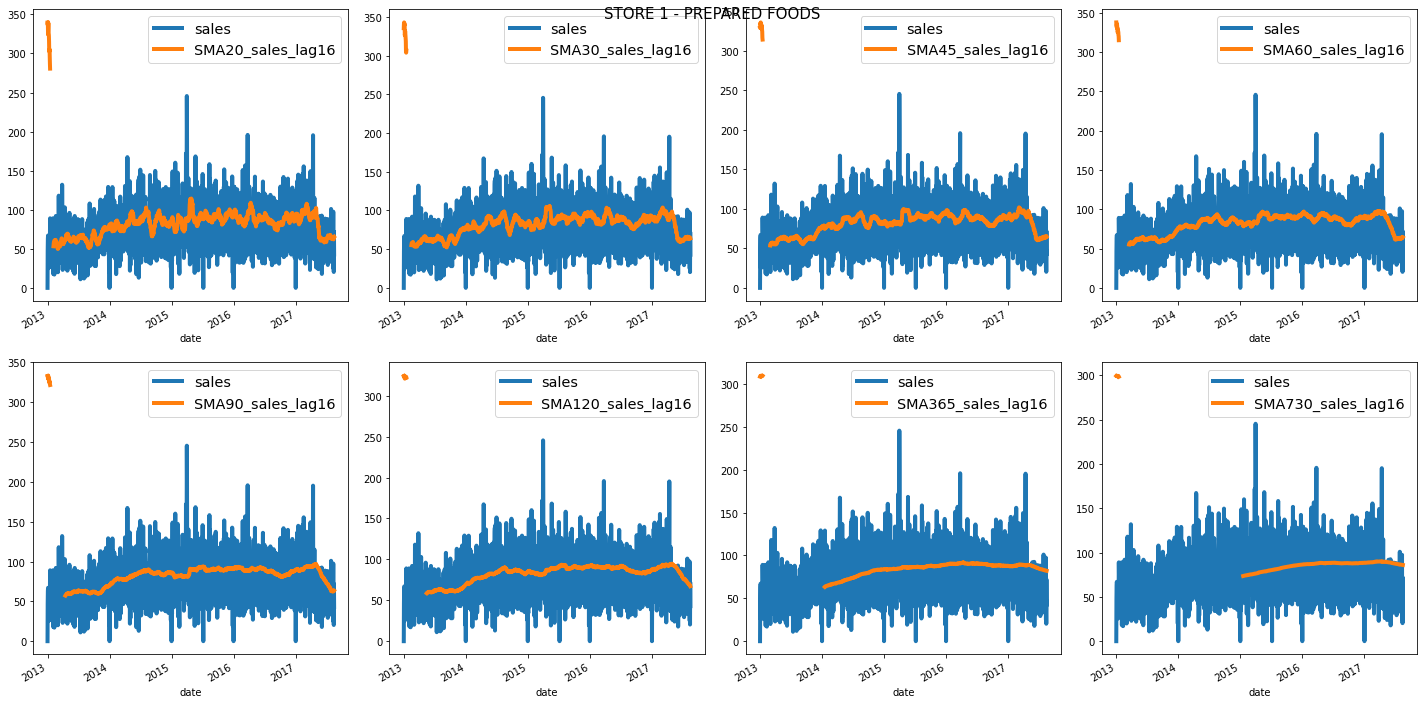

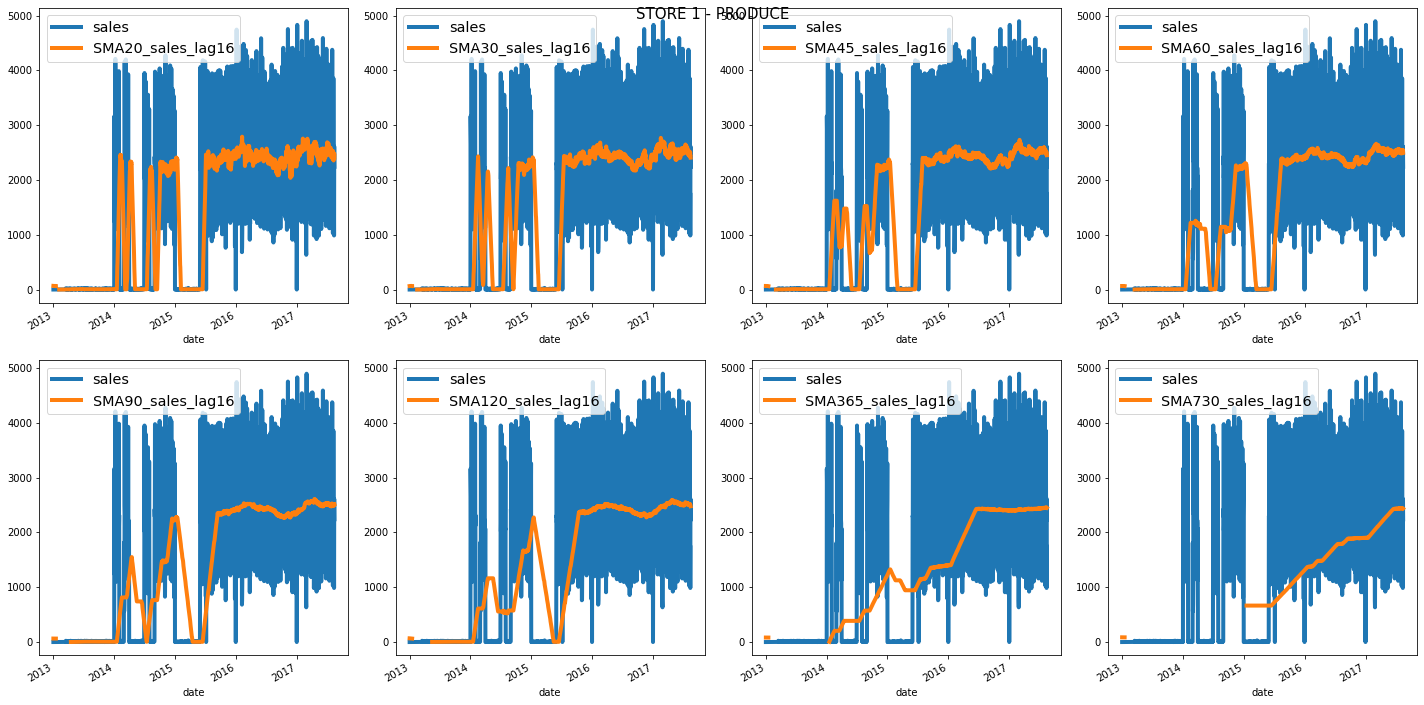

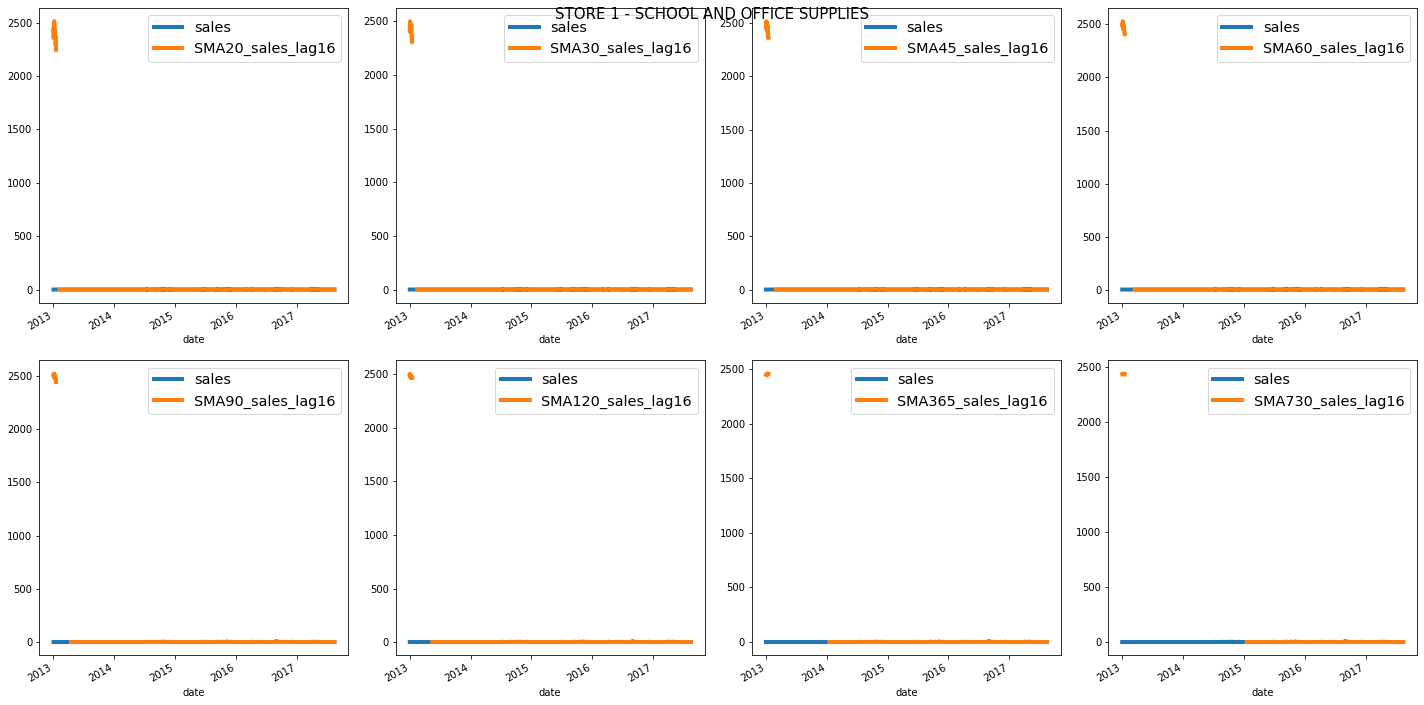

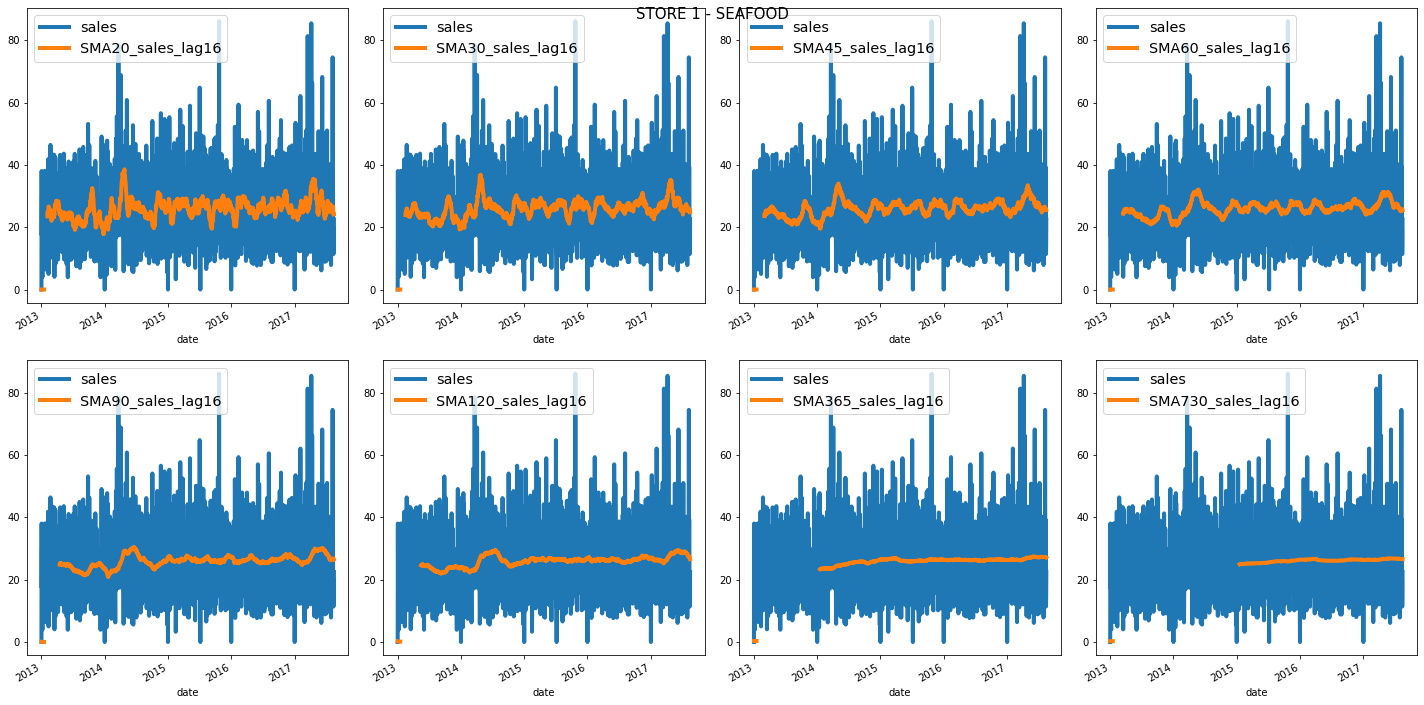

In [ ]:
b = a[(a.store_nbr == 1)].set_index("date")
for i in b.family.unique():
    fig, ax = plt.subplots(2,4,figsize=(20,10))
    b[b.family == i][["sales", "SMA20_sales_lag16"]].plot(legend = True, ax = ax[0,0], linewidth = 4)
    b[b.family == i][["sales", "SMA30_sales_lag16"]].plot(legend = True, ax = ax[0,1], linewidth = 4)
    b[b.family == i][["sales", "SMA45_sales_lag16"]].plot(legend = True, ax = ax[0,2], linewidth = 4)
    b[b.family == i][["sales", "SMA60_sales_lag16"]].plot(legend = True, ax = ax[0,3], linewidth = 4)
    b[b.family == i][["sales", "SMA90_sales_lag16"]].plot(legend = True, ax = ax[1,0], linewidth = 4)
    b[b.family == i][["sales", "SMA120_sales_lag16"]].plot(legend = True, ax = ax[1,1], linewidth = 4)
    b[b.family == i][["sales", "SMA365_sales_lag16"]].plot(legend = True, ax = ax[1,2], linewidth = 4)
    b[b.family == i][["sales", "SMA730_sales_lag16"]].plot(legend = True, ax = ax[1,3], linewidth = 4)
    plt.suptitle("STORE 1 - "+i, fontsize = 15)
    plt.tight_layout(pad = 1.5)
    for j in range(0,4):
        ax[0,j].legend(fontsize="x-large")
        ax[1,j].legend(fontsize="x-large")
    plt.show()

Ini adalah kode yang menggunakan module matplotlib untuk membuat visualisasi data. Pertama, dataframe a diubah sehingga hanya menampilkan data untuk toko dengan nomor 1, kemudian index dataframe diubah menjadi kolom "date". Kemudian, dilakukan loop melalui semua nilai unik dari kolom family dalam dataframe b. Pada setiap iterasi loop, fungsi membuat figure dengan ukuran 20x10 inci dan 8 subplot dengan ukuran 2x4. Kemudian, dataframe b diplot dengan kolom sales sebagai sumbu y dan kolom-kolom SMA (moving average) sebagai sumbu x pada masing-masing subplot. Setelah itu, judul figure ditambahkan dengan "STORE 1 -" diikuti dengan nilai family yang sedang diiterasi, lalu figure ditampilkan ke layar.